# OrangeJuice Data Exploration in R

In this notebook, we use R to explore the Orange Juice dataset in R package `bayesm`. This dataset is used in the retail forecasting benchmark OrangeJuice_Pt_3Weeks_Weekly of TSPerf. 

To run this notebook, please first create (if you haven't) and activate `tsperf` conda environment by running the following command from `TSPerf` directory:  
`conda env create --file ./common/conda_dependencies.yml`  
`conda activate tsperf`  
Then, you can add the conda environement to the list of kernels in Jupyter notebook via  
`ipython kernel install --user --name=tsperf`

In [1]:
# Import libraries
require('tseries')
require('dplyr')
require('ggplot2')

Loading required package: tseries
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: ggplot2


## Data preparation

In [2]:
# Load data
data_dir = file.path('..', 'data')
sales <- read.csv(file.path(data_dir, 'yx.csv'))
storedemo <- read.csv(file.path(data_dir, 'storedemo.csv'))
# Show first few rows of sales data
cat('First few rows of sales data: \n')
print(head(sales, 4))
cat('\n')
# Show first few rows of store demographic data
cat('First few rows of store demographic data: \n')
print(head(storedemo, 4))

First few rows of sales data: 
  store brand week  logmove constant     price1     price2     price3
1     2     1   40 9.018695        1 0.06046875 0.06049653 0.04203125
2     2     1   46 8.723231        1 0.06046875 0.06031250 0.04515625
3     2     1   47 8.253228        1 0.06046875 0.06031250 0.04515625
4     2     1   48 8.987197        1 0.06046875 0.06031250 0.04984375
      price4     price5     price6     price7     price8     price9    price10
1 0.02953125 0.04953125 0.05302083 0.03890625 0.04140625 0.02890625 0.02484375
2 0.04671875 0.04953125 0.04781250 0.04578125 0.02796875 0.04296875 0.04203125
3 0.04671875 0.03734375 0.05302083 0.04578125 0.04140625 0.04812500 0.03265625
4 0.03734375 0.04953125 0.05302083 0.04578125 0.04140625 0.04234375 0.03265625
     price11 deal feat   profit
1 0.03898438    1    0 37.99233
2 0.03898438    0    0 30.12667
3 0.03898438    0    0 30.00000
4 0.03898438    0    0 29.95000

First few rows of store demographic data: 
  STORE     AGE60   

In [3]:
# Check number of time series and lengths
cat(paste0('number of stores is ', length(unique(sales$store)), '\n'))
cat(paste0('number of brands is ', length(unique(sales$brand)), '\n'))
ts_lengths <- sales %>% group_by(store, brand) %>% summarise(len=n())
cat(paste0('number of time series is ', nrow(ts_lengths), '\n'))
cat('length distribution of the time series: \n')
sum <- summary(ts_lengths$len)
sum['Std'] <- round(sd(ts_lengths$len), 2)
print(sum)

number of stores is 83
number of brands is 11
number of time series is 913
length distribution of the time series: 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.     Std 
  87.00  115.00  117.00  116.25  119.00  121.00    4.73 


In [4]:
# Fill missing gaps with zeros
store_list <- unique(sales$store)
brand_list <- unique(sales$brand)
week_list <- min(sales$week):max(sales$week)
data_grid <- expand.grid(store=store_list, brand=brand_list, week=week_list)
cat(paste0('Total number of rows before filling gaps is ', nrow(sales), '\n'))
sales <- merge(x=data_grid, y=sales, by=c('store', 'brand', 'week'), all.x=TRUE)
sales[is.na(sales)] <- 0
cat(paste0('Total number of rows after filling gaps is ', nrow(sales), '\n'))

Total number of rows before filling gaps is 106139
Total number of rows after filling gaps is 110473


In [5]:
# Merge sales and store demographics
sales <- merge(sales, storedemo, by.x='store', by.y='STORE', all.x=TRUE)

In [6]:
# Compute unit sales
roundexp <- function(x) if(x>0) {round(exp(x))} else 0
sales$move <- sapply(sales$logmove, roundexp)

## Visualize sample data & check profit column

We find there are occasional missing values in some time series. It's not clear if the profit column is determined by the unit sales. Thus, for safety we don't use profit to train our forecasting models. 

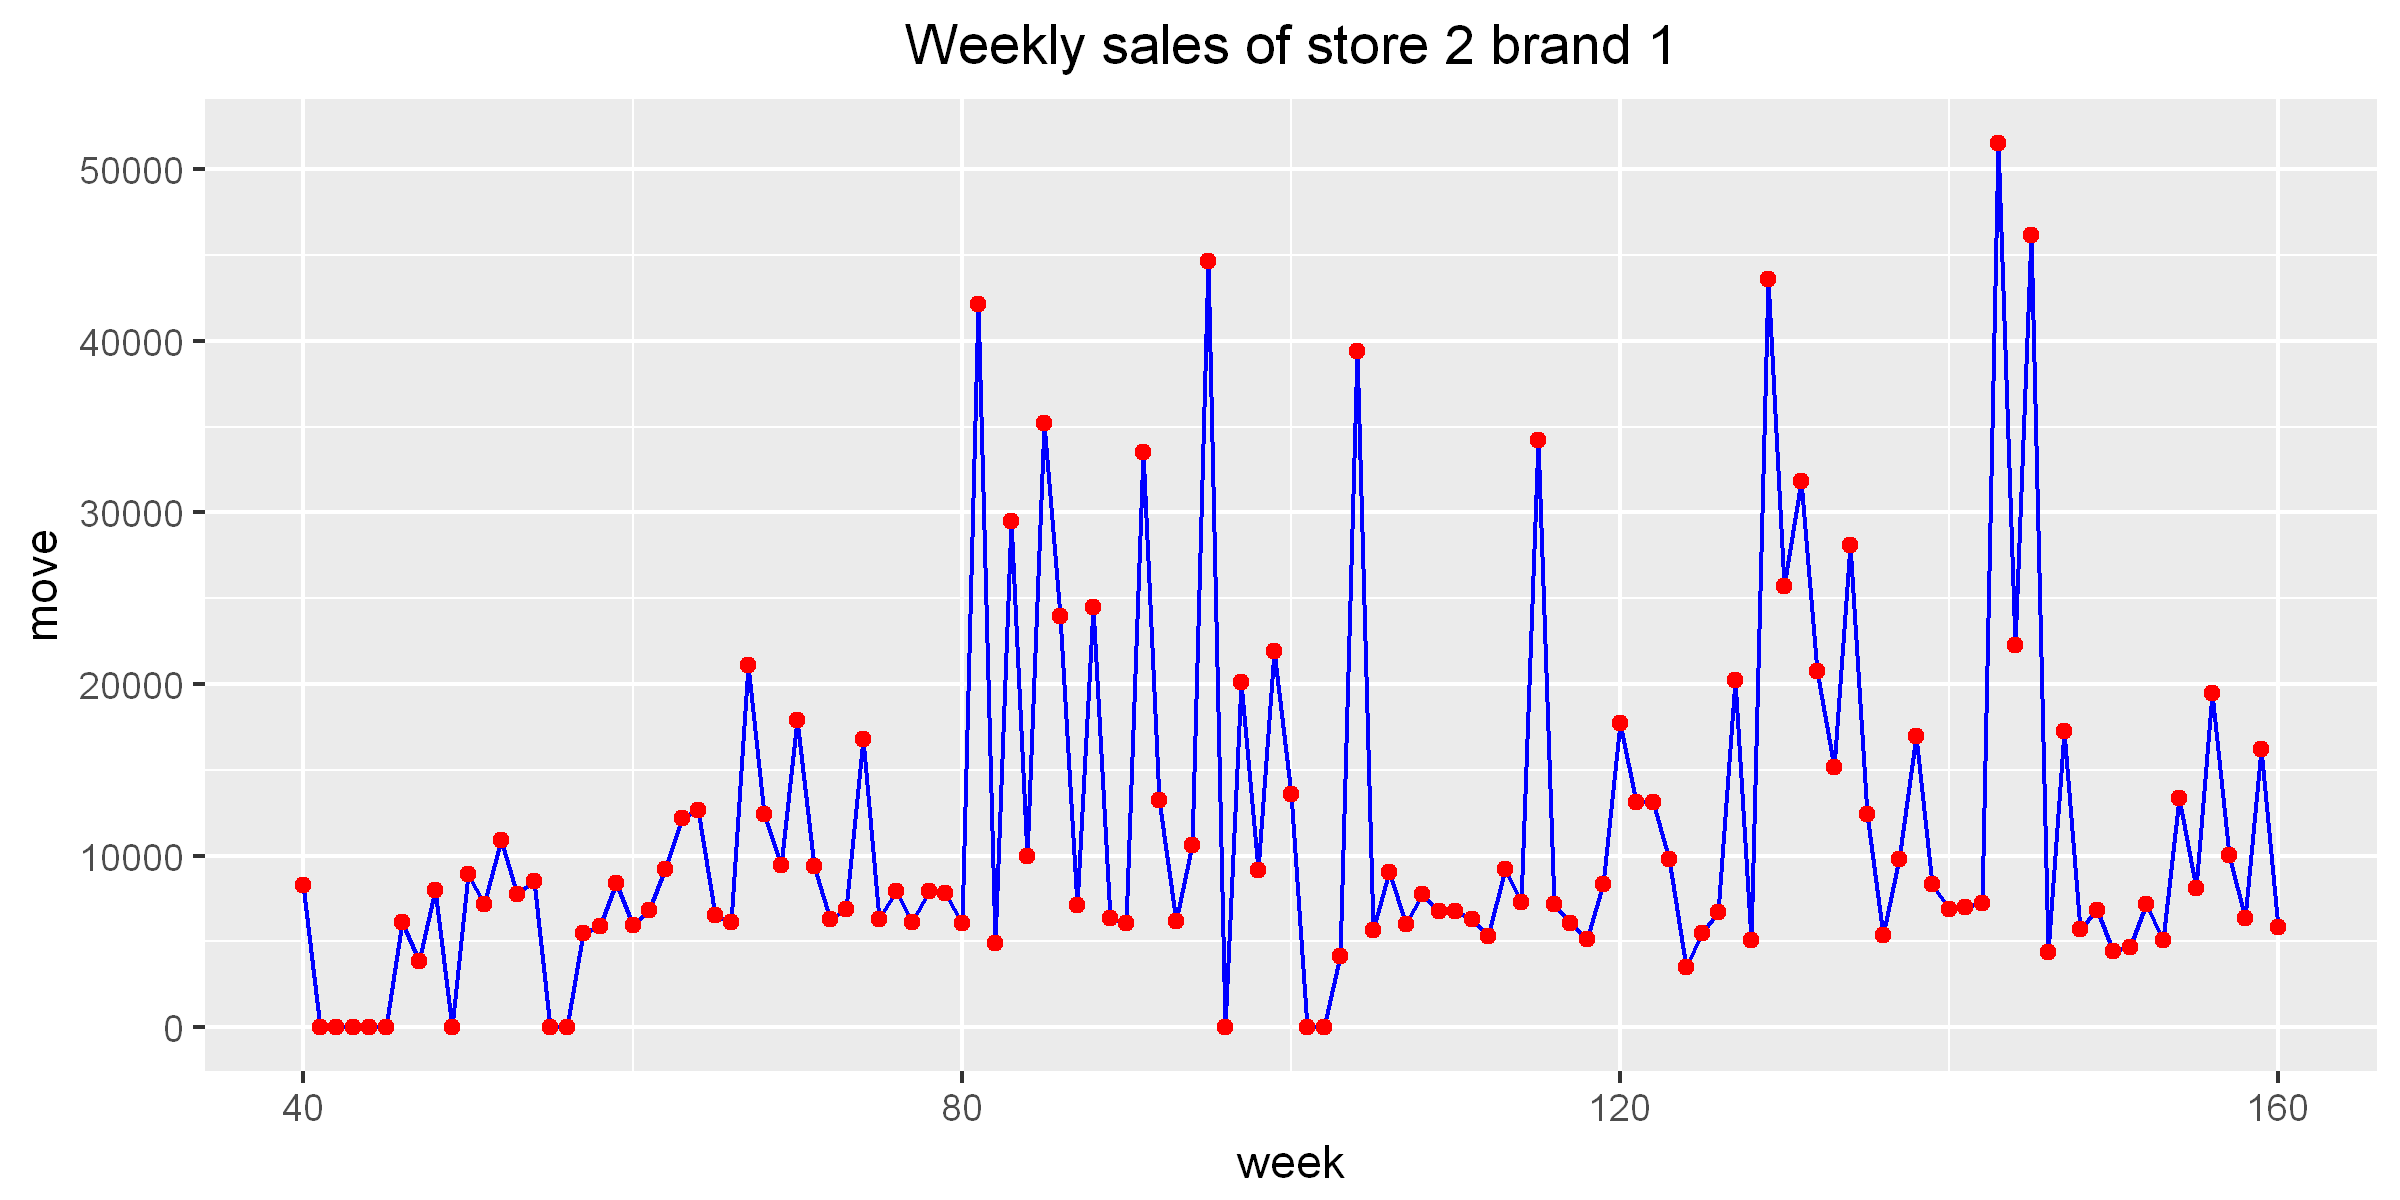

In [7]:
# Plot sample time series of sales
sample_store <- 2
sample_brand <- 1
sales_sub <- filter(sales, store == sample_store, brand == sample_brand)
# Show images inline
options(jupyter.plot_mimetypes = 'image/png')
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res=300)
ggplot(sales_sub, aes(week, move), dpi=800) + geom_line(color='blue') + geom_point(color='red') +
 ggtitle(paste0('Weekly sales of store ', sample_store, ' brand ', sample_brand)) +
 theme(plot.title = element_text(hjust = 0.5))

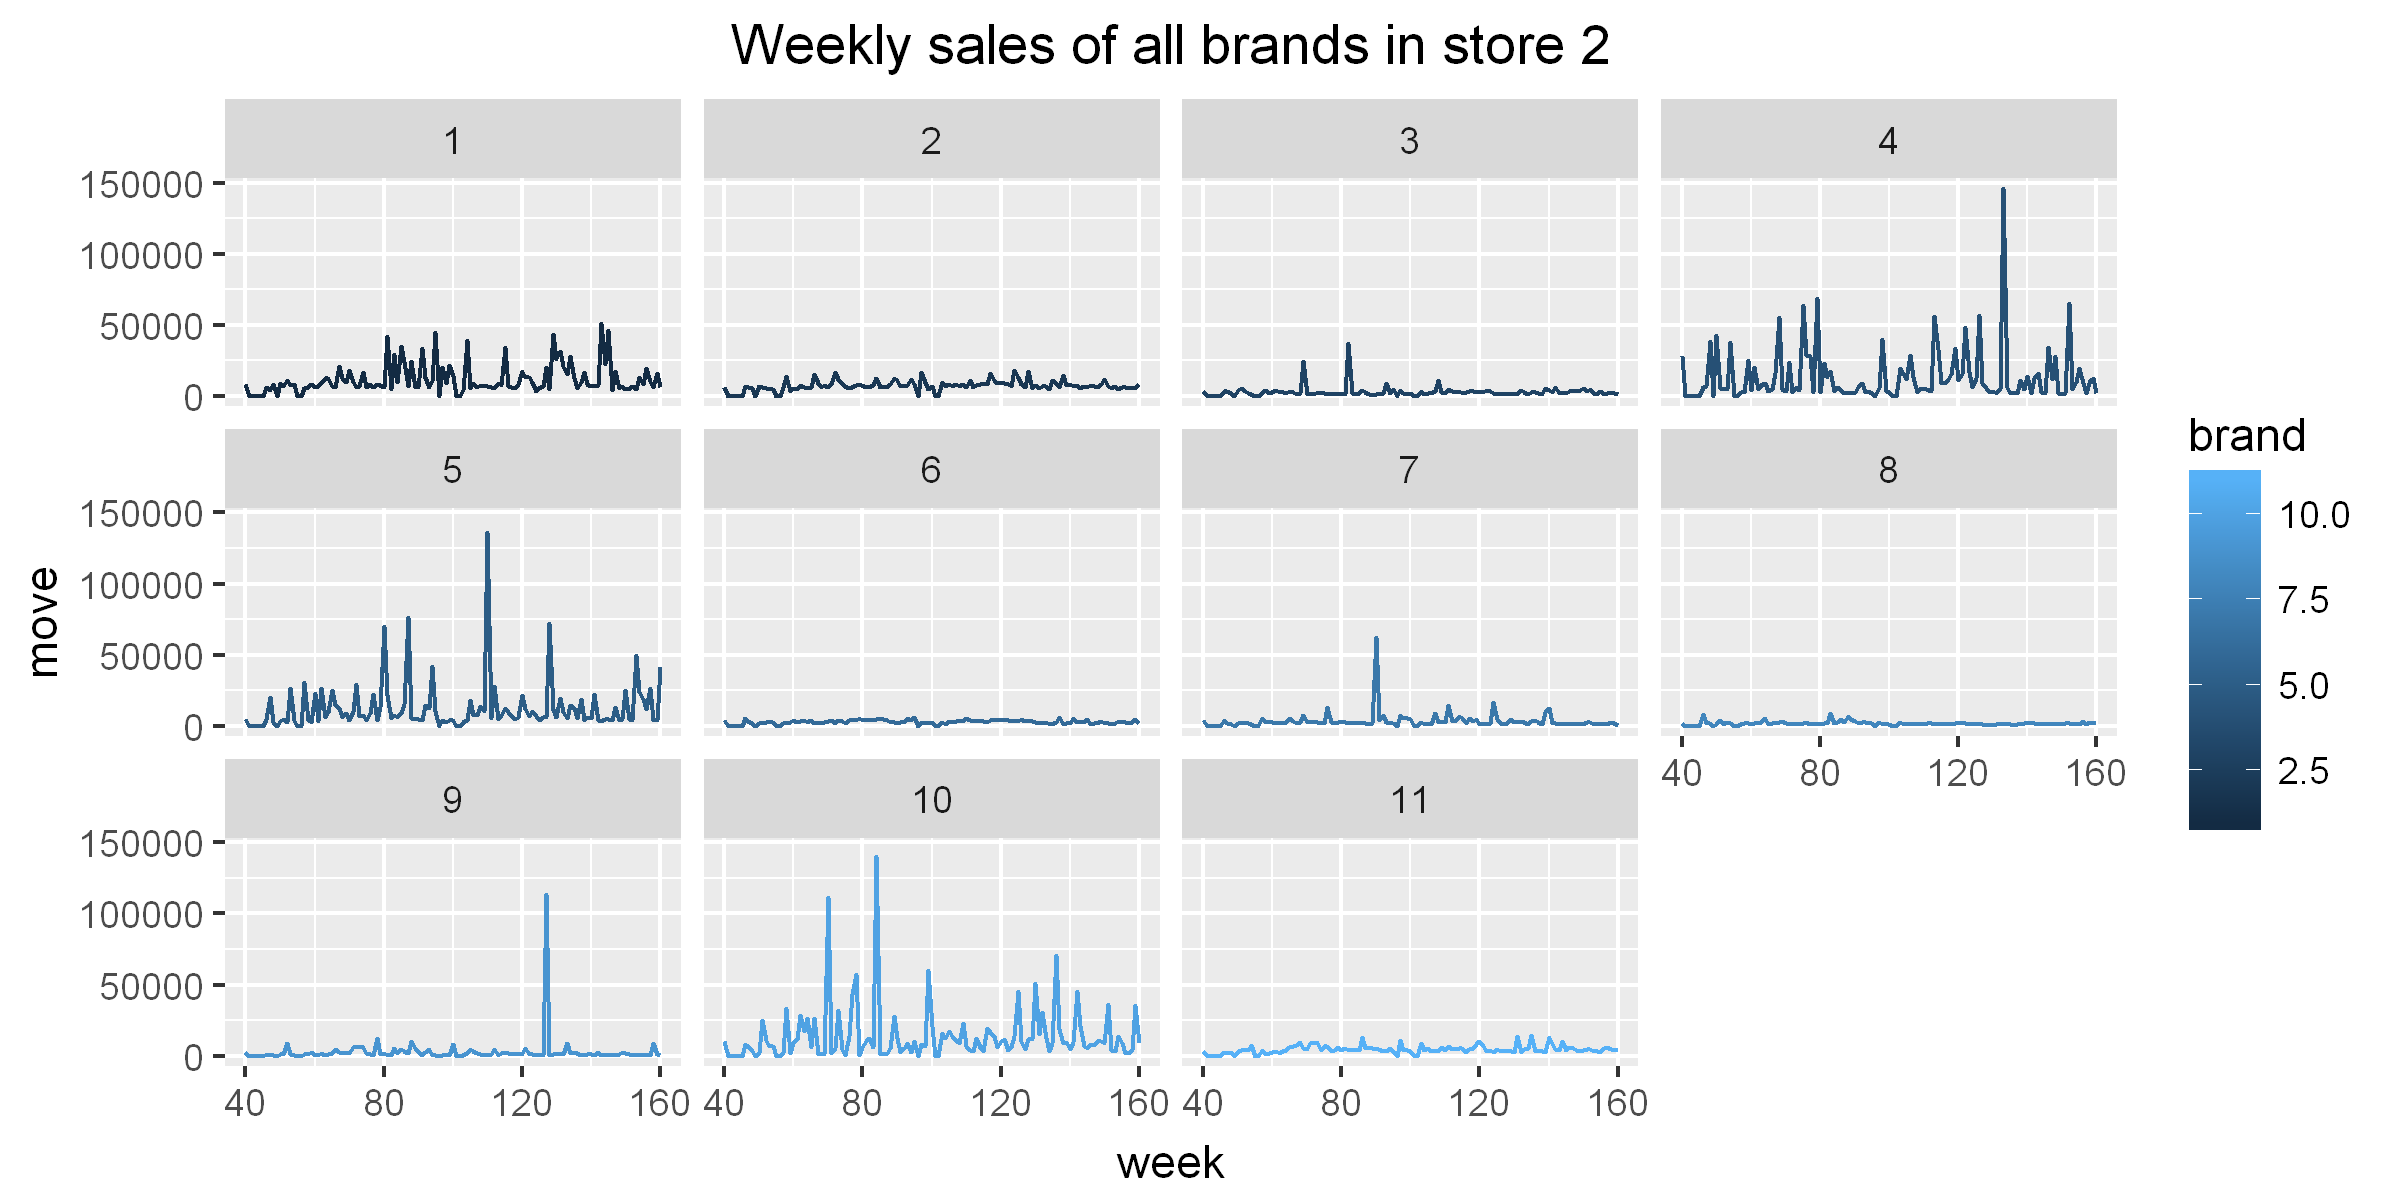

In [8]:
# Plot sales of all brands in a sample store
sample_store <- 2
sales_sub <- filter(sales, store == sample_store)
ggplot(sales_sub, aes(week, move, color=brand)) + geom_line() +  facet_wrap(~brand, ncol = 4) +
 ggtitle(paste0('Weekly sales of all brands in store ', sample_store)) +
 theme(plot.title = element_text(hjust = 0.5)) 

In [9]:
# Check correlation between profit and unit sales
# For safety we don't use profit to train our forecasting models. 
sales_brand1 <- select(filter(sales, brand == 1), c('store', 'brand', 'move', 'profit', 'price1'))
cat(paste0('Number of rows in the sample data is ', nrow(sales_brand1), '\n'))
cat(paste0('Correlation between profit and unit sales is ', cor(sales_brand1$profit, sales_brand1$move)))

Number of rows in the sample data is 10043
Correlation between profit and unit sales is -0.353070335104515

## Impact of demographics, brand, and store

We find that the impact of demographic features on sales is quite small, while brand and store seem to have significant impact on sales.

In [10]:
# Check correlation between unit sales and each of the store demographic features
# The correlation is low suggesting that the store demographic features might be not helpful.
demographic_cols <- colnames(storedemo)[-1]
cat('Correlation between unit sales and each demographic feature: \n')
cor(sales$move, select(sales, demographic_cols))
cat('Correlation between log-scale sales and each demographic feature: \n')
cor(sales$logmove, select(sales, demographic_cols))

Correlation between unit sales and each demographic feature: 


AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0.04740896,-0.02659913,0.07458097,-0.05048395,0.0009395237,-0.06346105,-0.02636236,0.03285901,-0.02725546,0.006354709,-0.07814384


Correlation between log-scale sales and each demographic feature: 


AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0.03467352,-0.01219991,0.04429252,-0.02318309,-0.02662919,-0.02305865,-0.002460179,-0.006033026,-0.0717991,0.02605046,-0.05945569


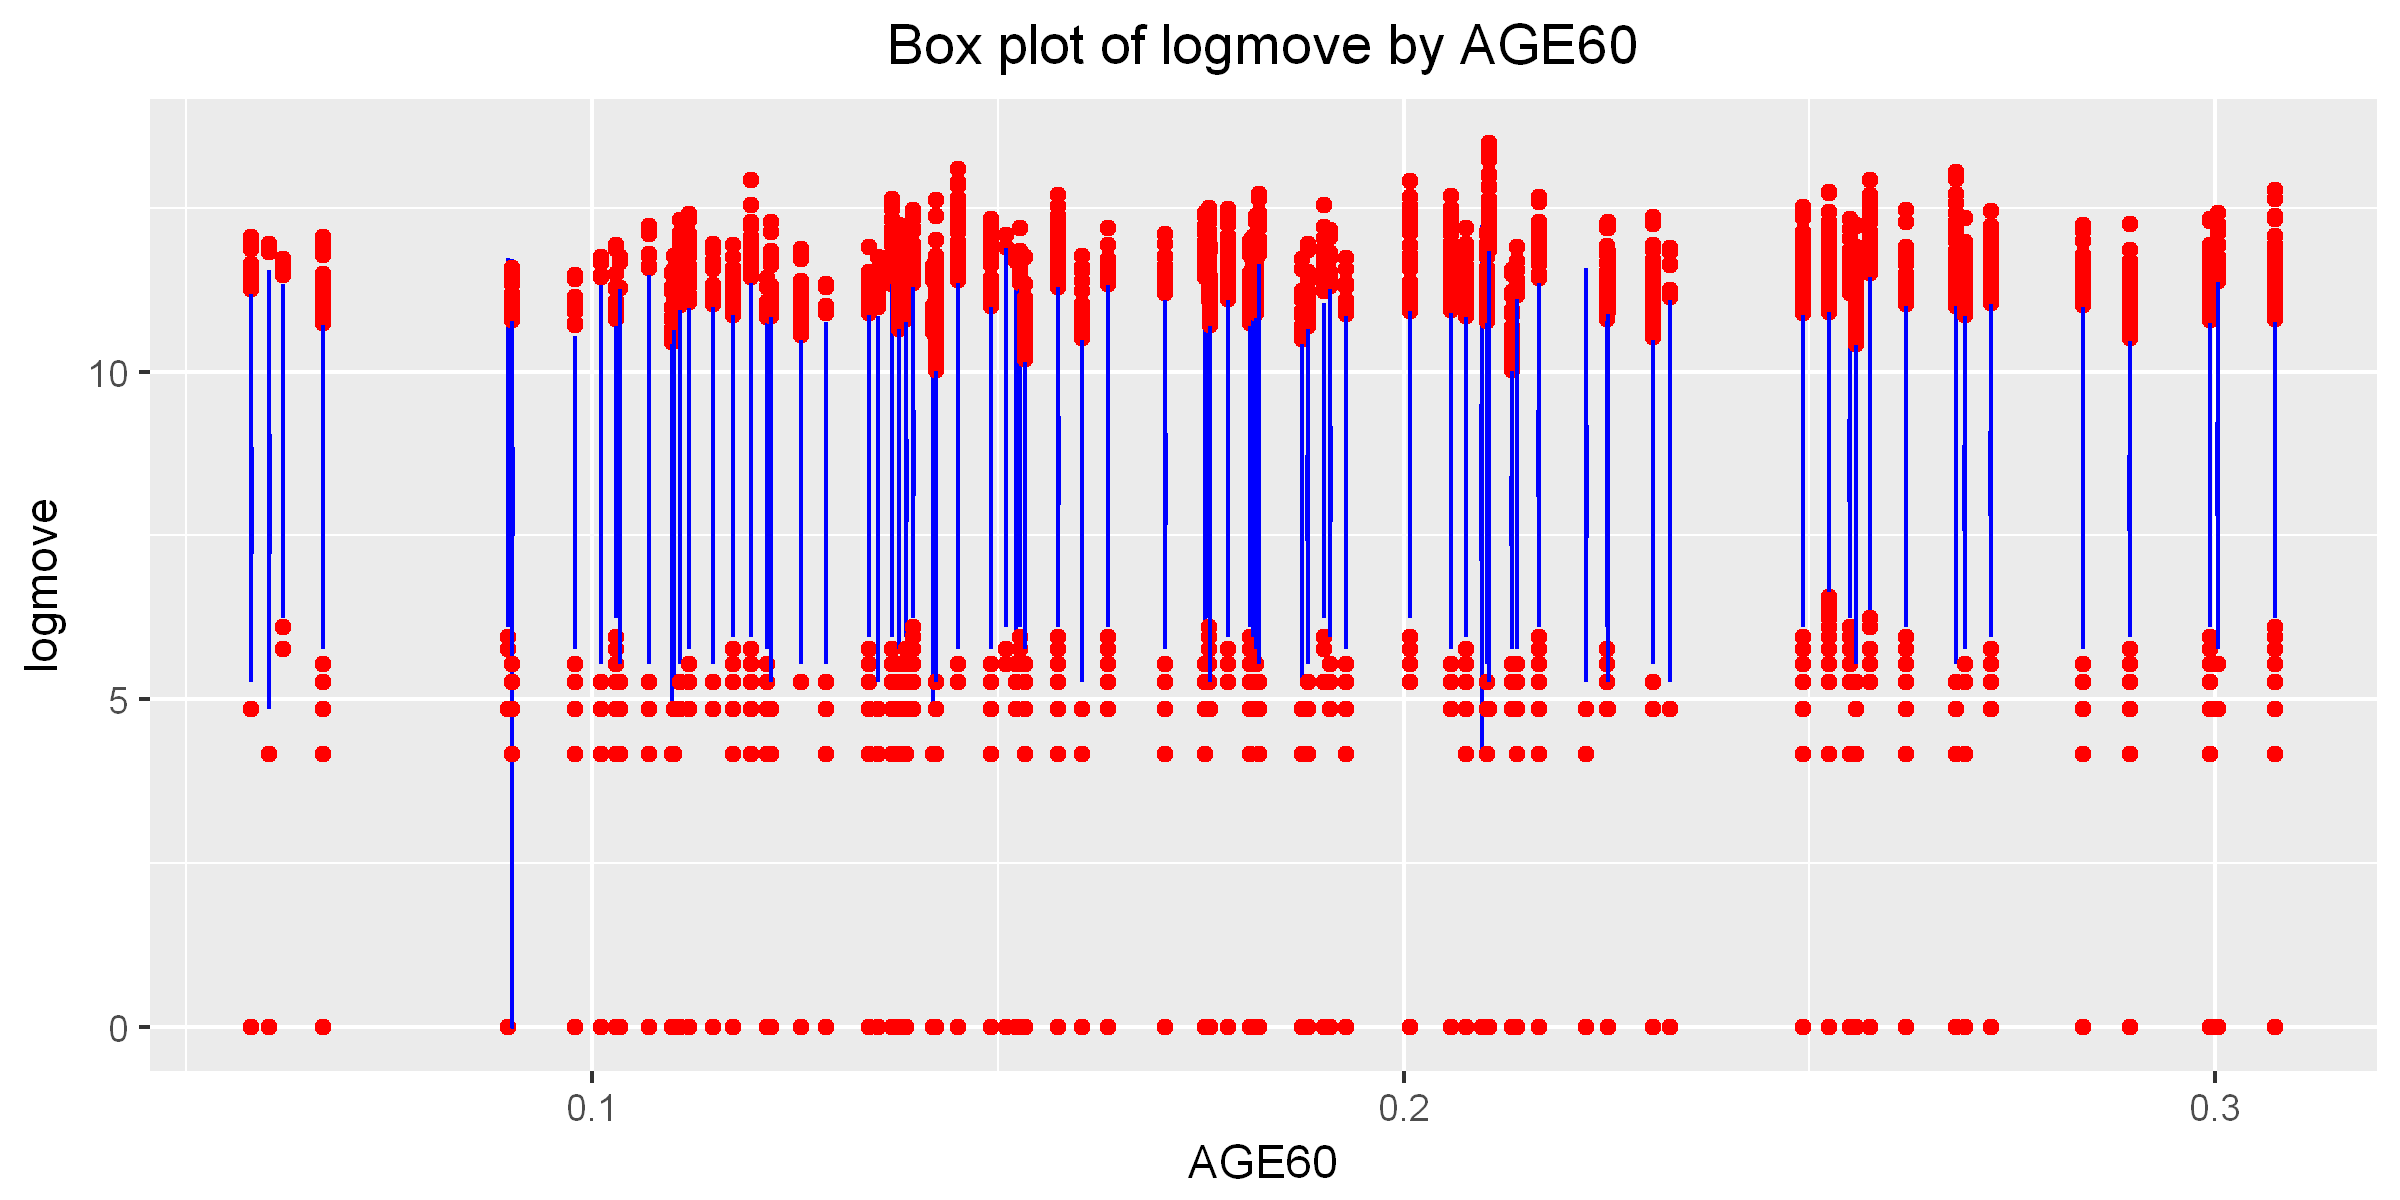

In [11]:
# Plot sales vs. AGE60
ggplot(sales, aes(x=AGE60, y=logmove, group=AGE60)) + geom_boxplot(color='blue', outlier.color='red') +
 ggtitle('Box plot of logmove by AGE60') +
 theme(plot.title = element_text(hjust = 0.5))

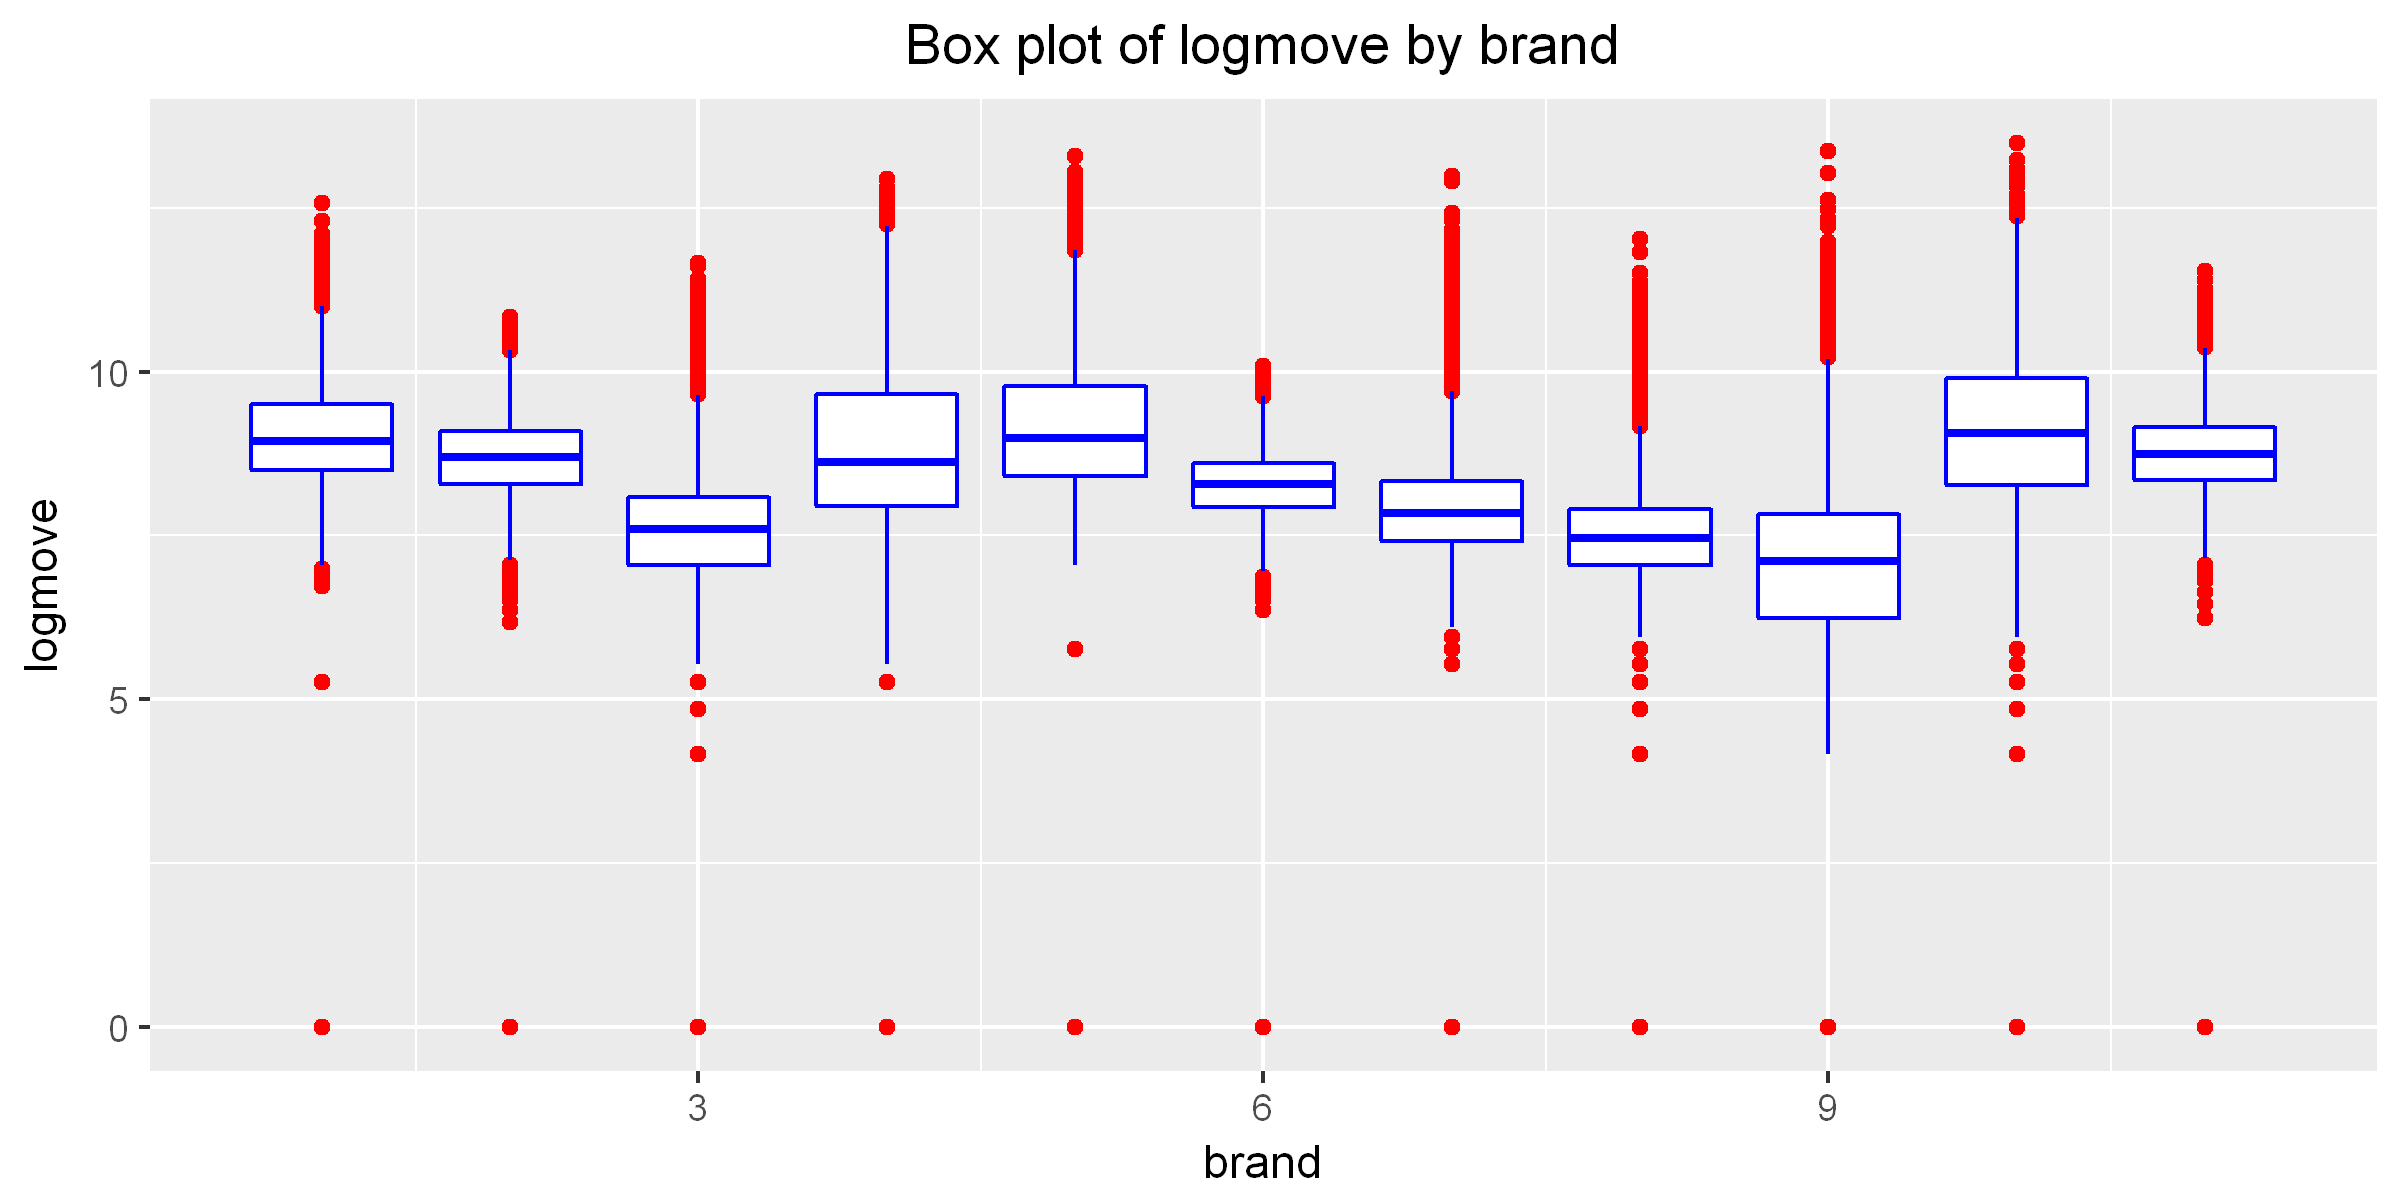

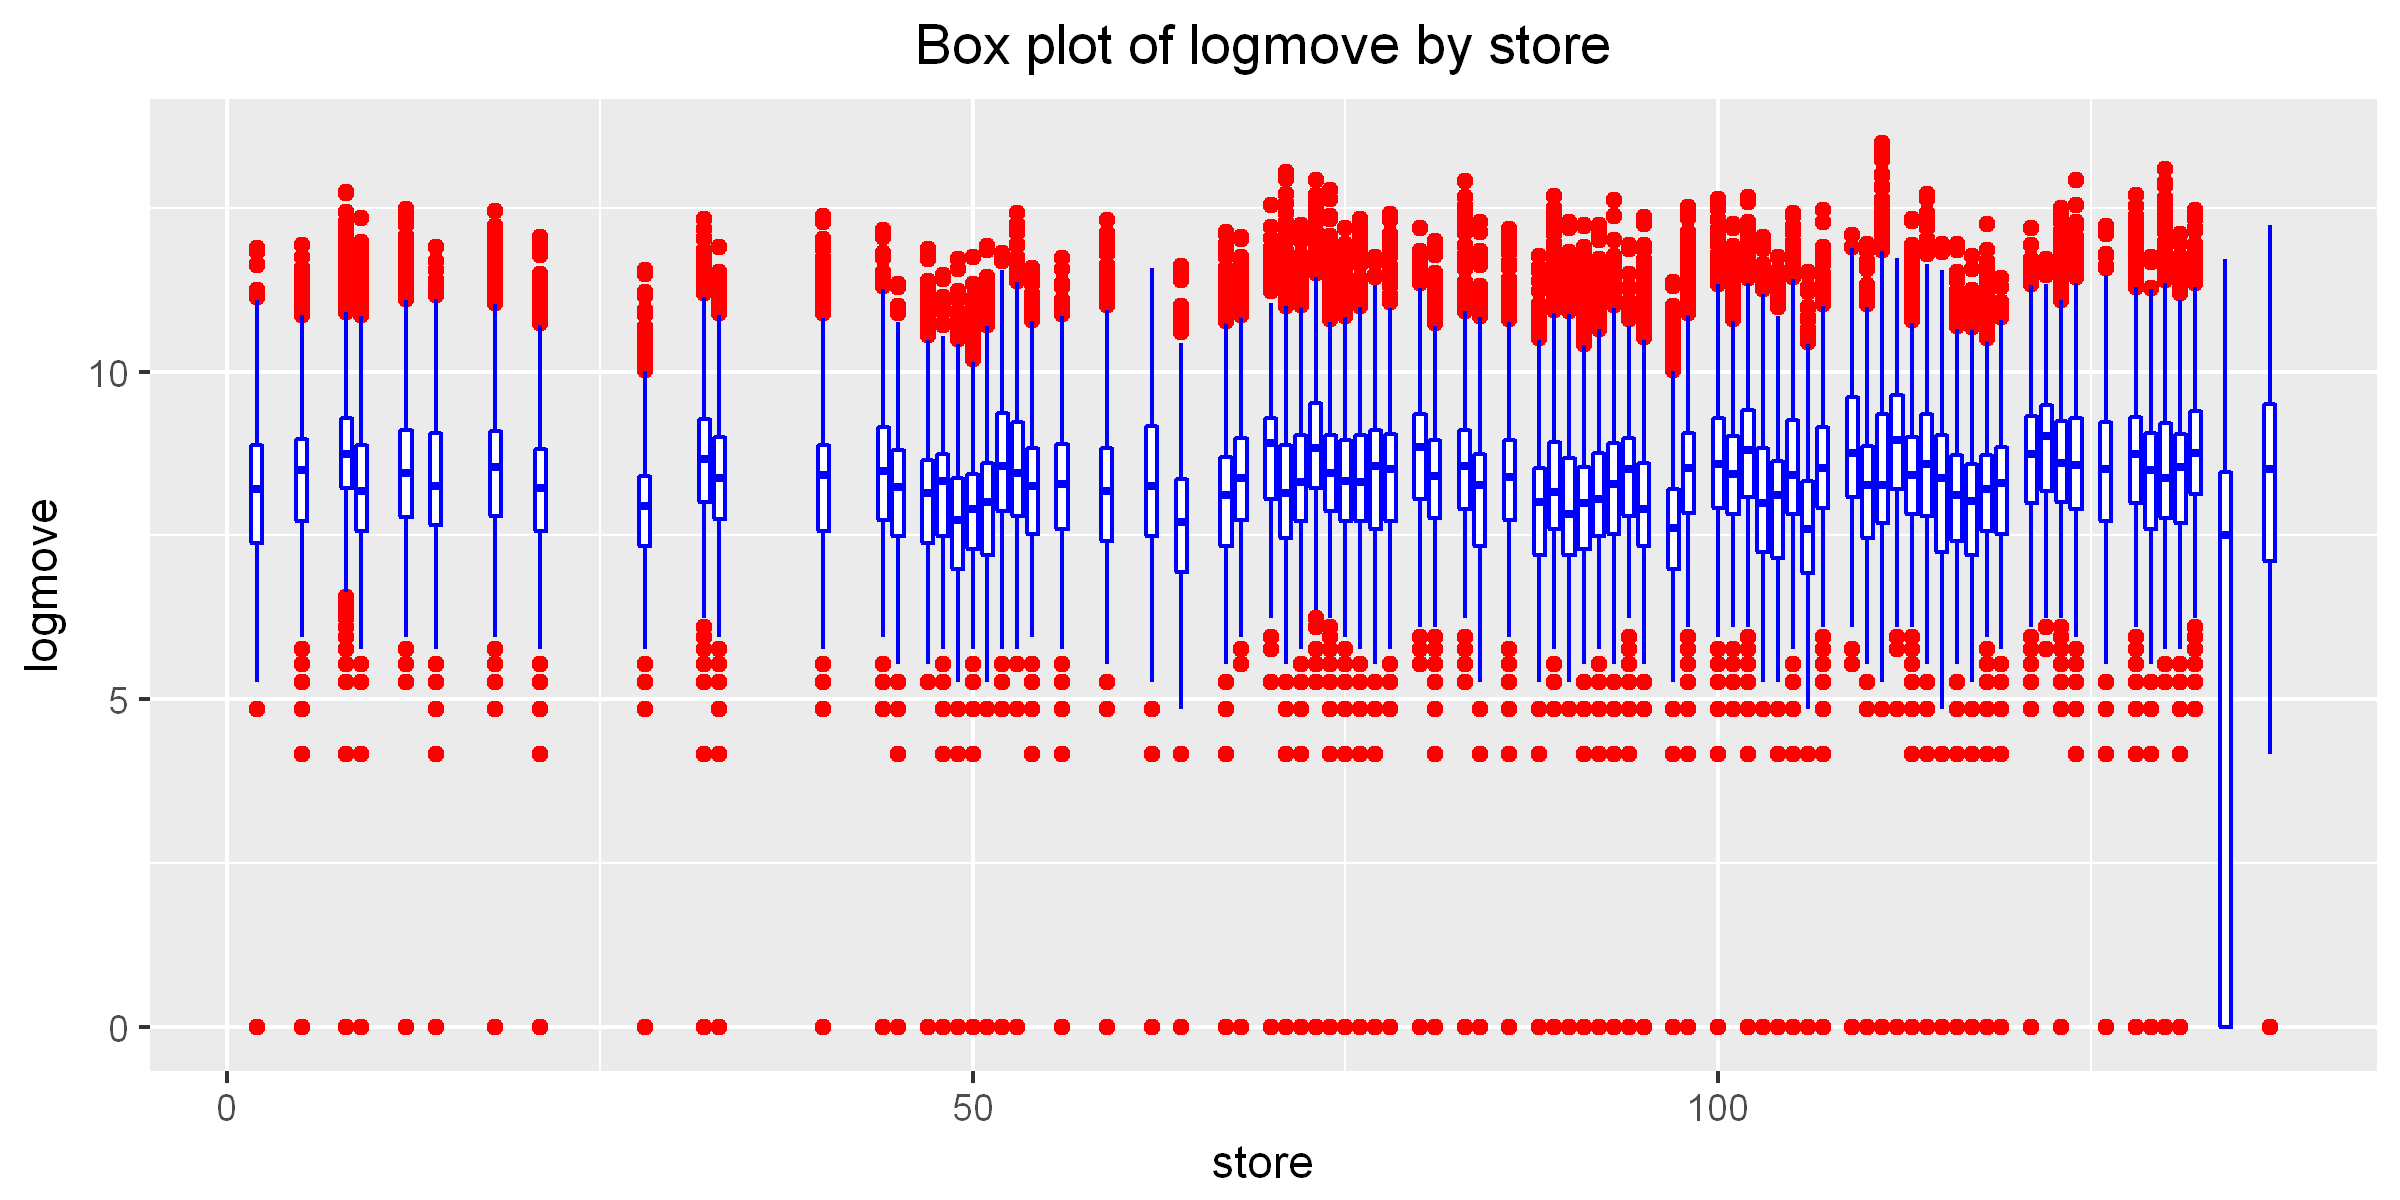

In [12]:
# Check sales across different brands and stores
ggplot(sales, aes(x=brand, y=logmove, group=brand)) + geom_boxplot(color='blue', outlier.color='red') +
 ggtitle('Box plot of logmove by brand') +
 theme(plot.title = element_text(hjust = 0.5))
ggplot(sales, aes(x=store, y=logmove, group=store)) + geom_boxplot(color='blue', outlier.color='red') +
 ggtitle('Box plot of logmove by store') +
 theme(plot.title = element_text(hjust = 0.5))

## Check seasonality & autocorrelation

Overall, we don't find a strong seasonality in the data. It seems that there is a weak yearly-seasonality according to the seasonal-trend-level decomposition and the autocorrelation values around the lag of 52 weeks. As a rough estimate, autocorrelation beyond 20 weeks is usually very small. 

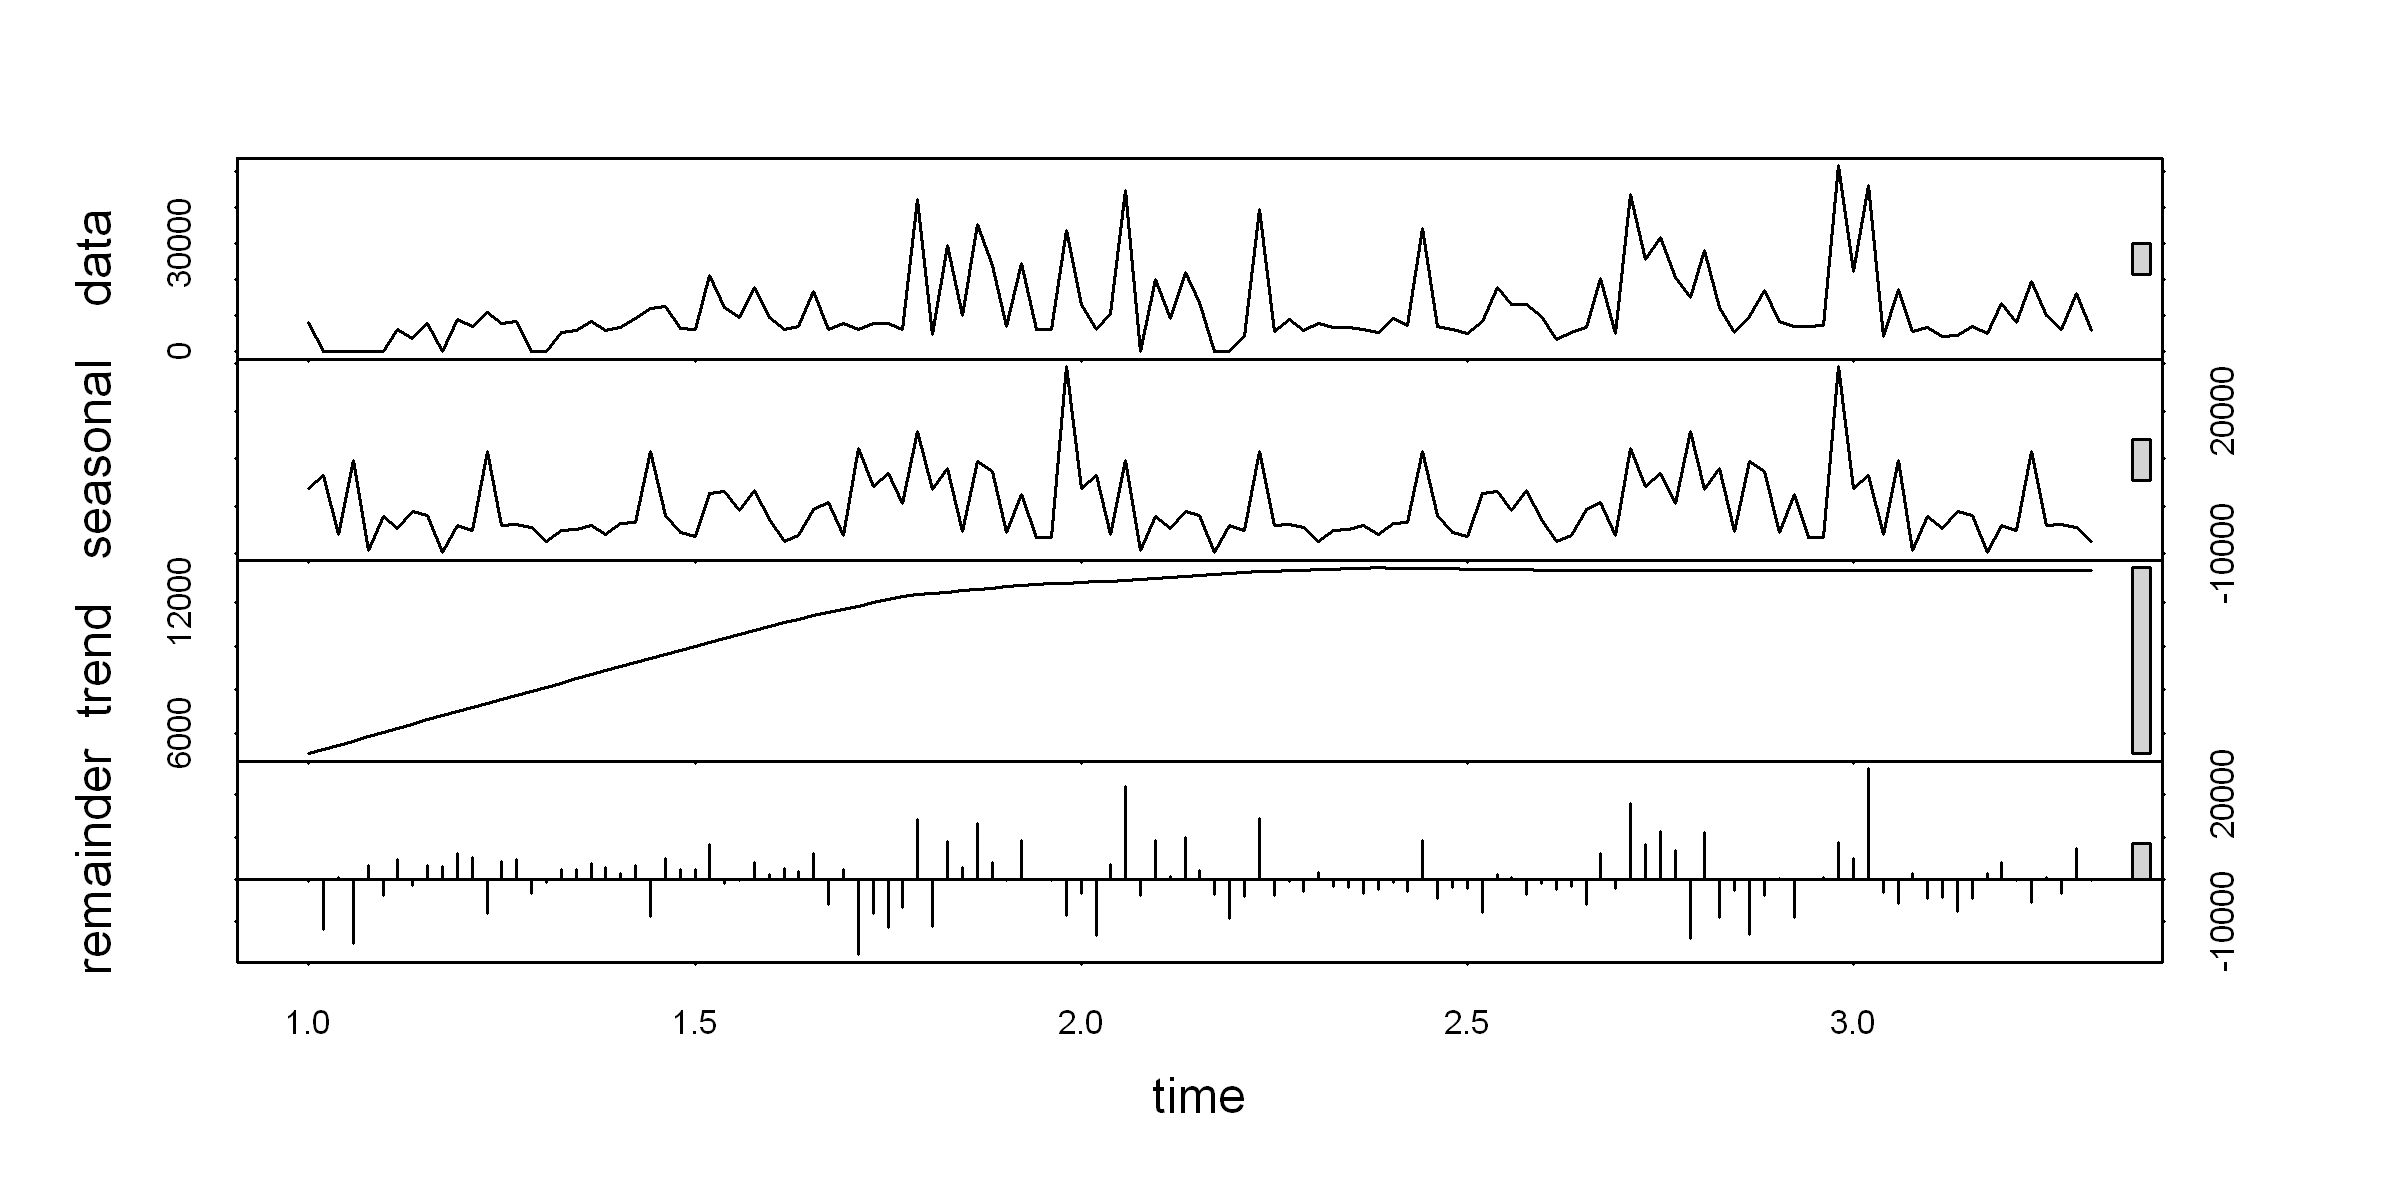

In [13]:
# Check Seasonality 
# Not much seasonality is found
sample_store <- 2
sample_brand <- 1
sales_sub <- filter(sales, store == sample_store, brand == sample_brand)
sales_sub_ts <- ts(sales_sub$move, frequency=52)
fit <- stl(sales_sub_ts, s.window='periodic')
plot(fit)

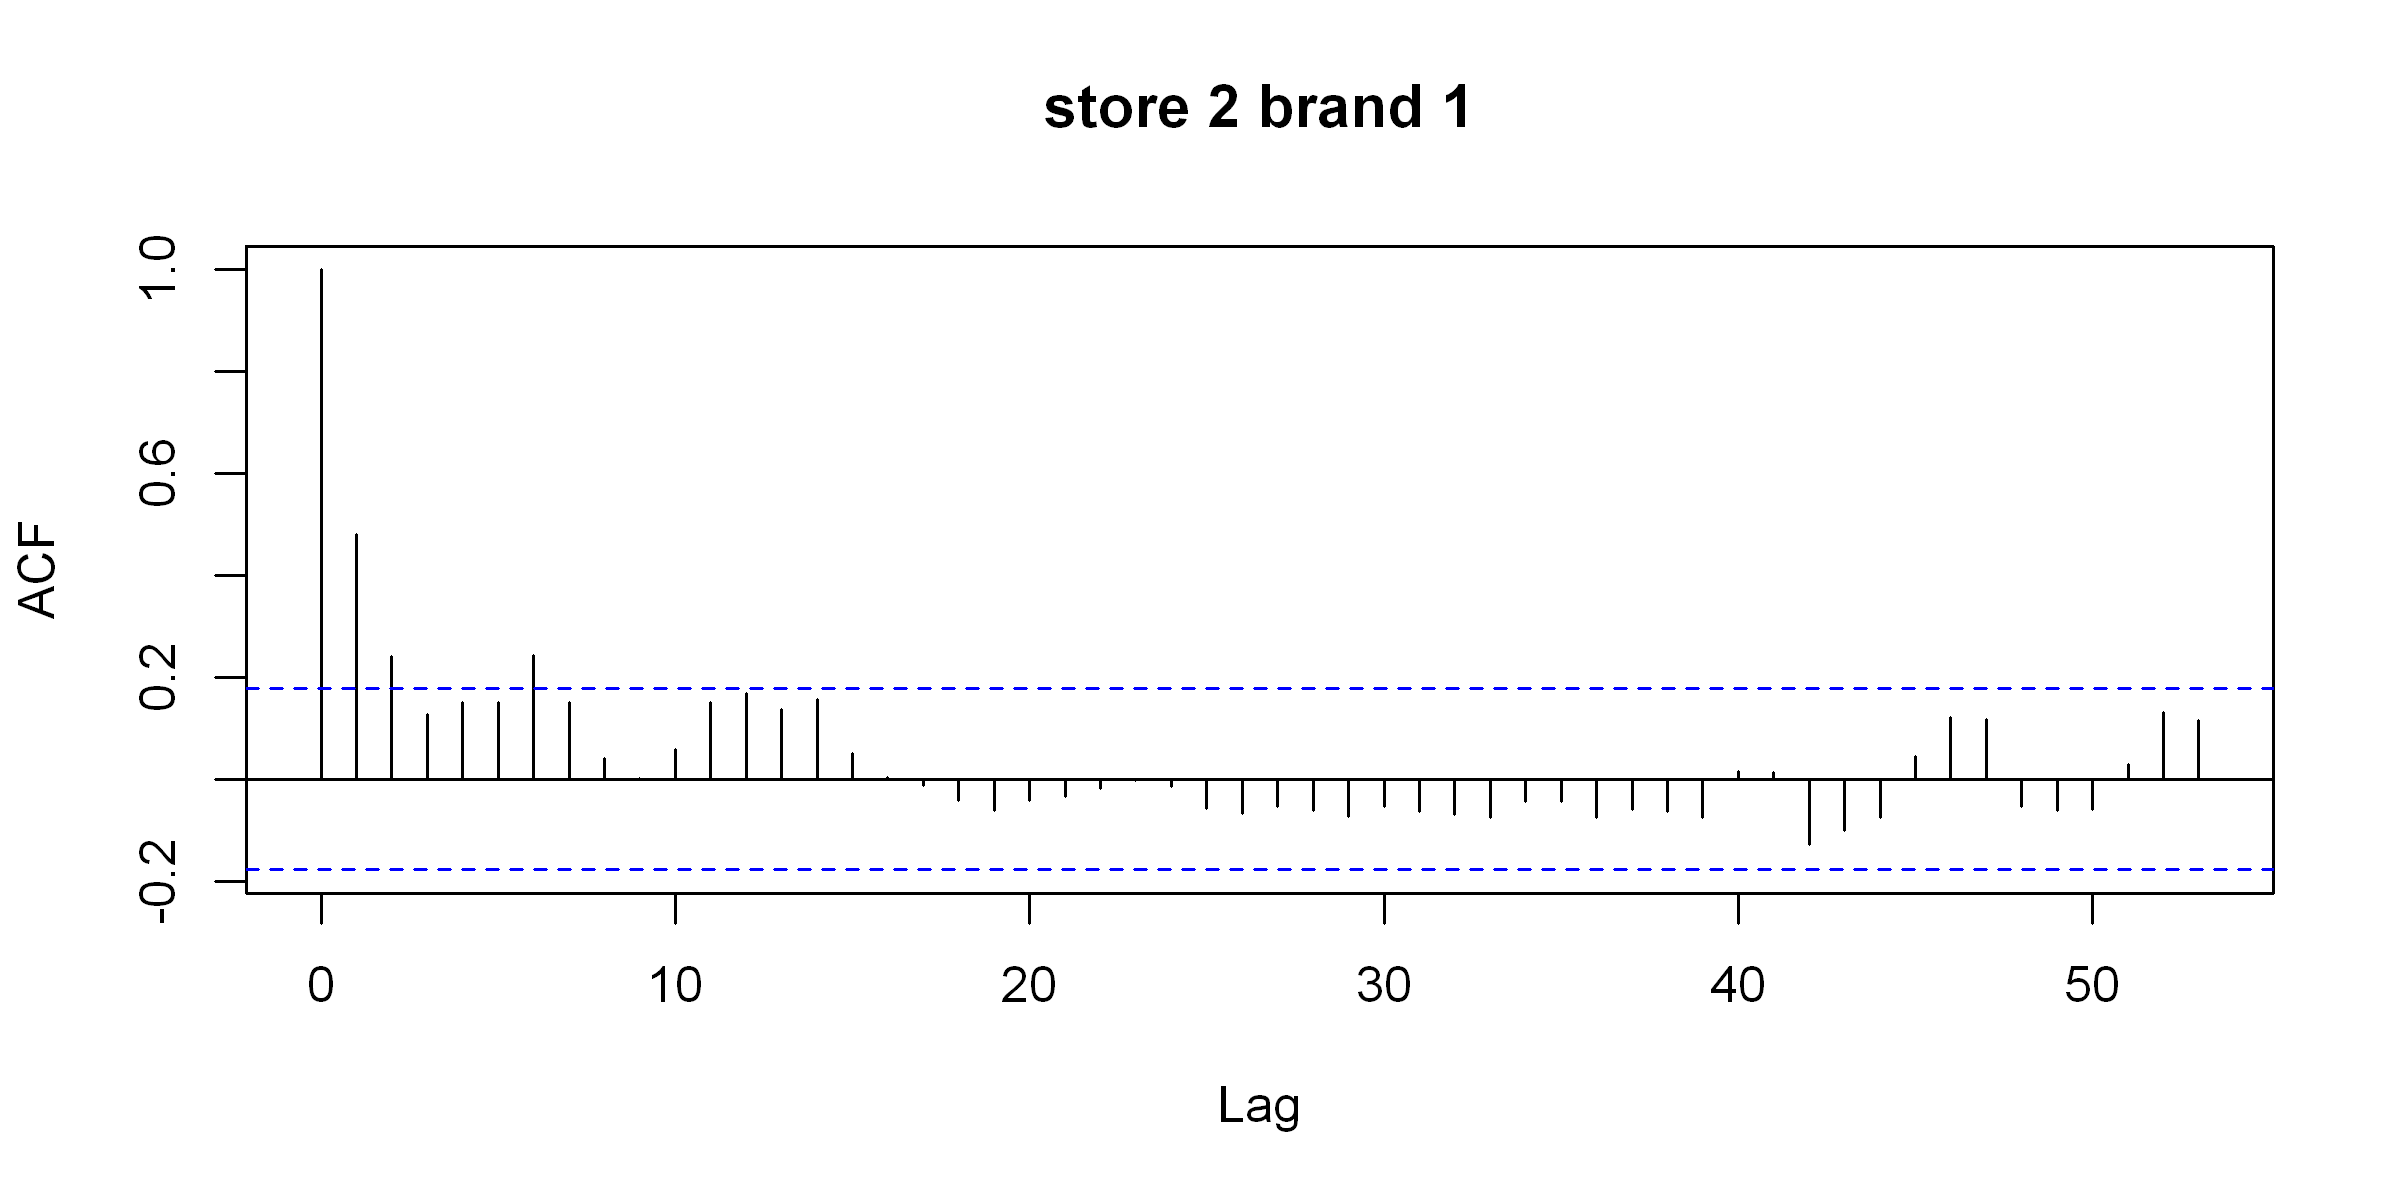

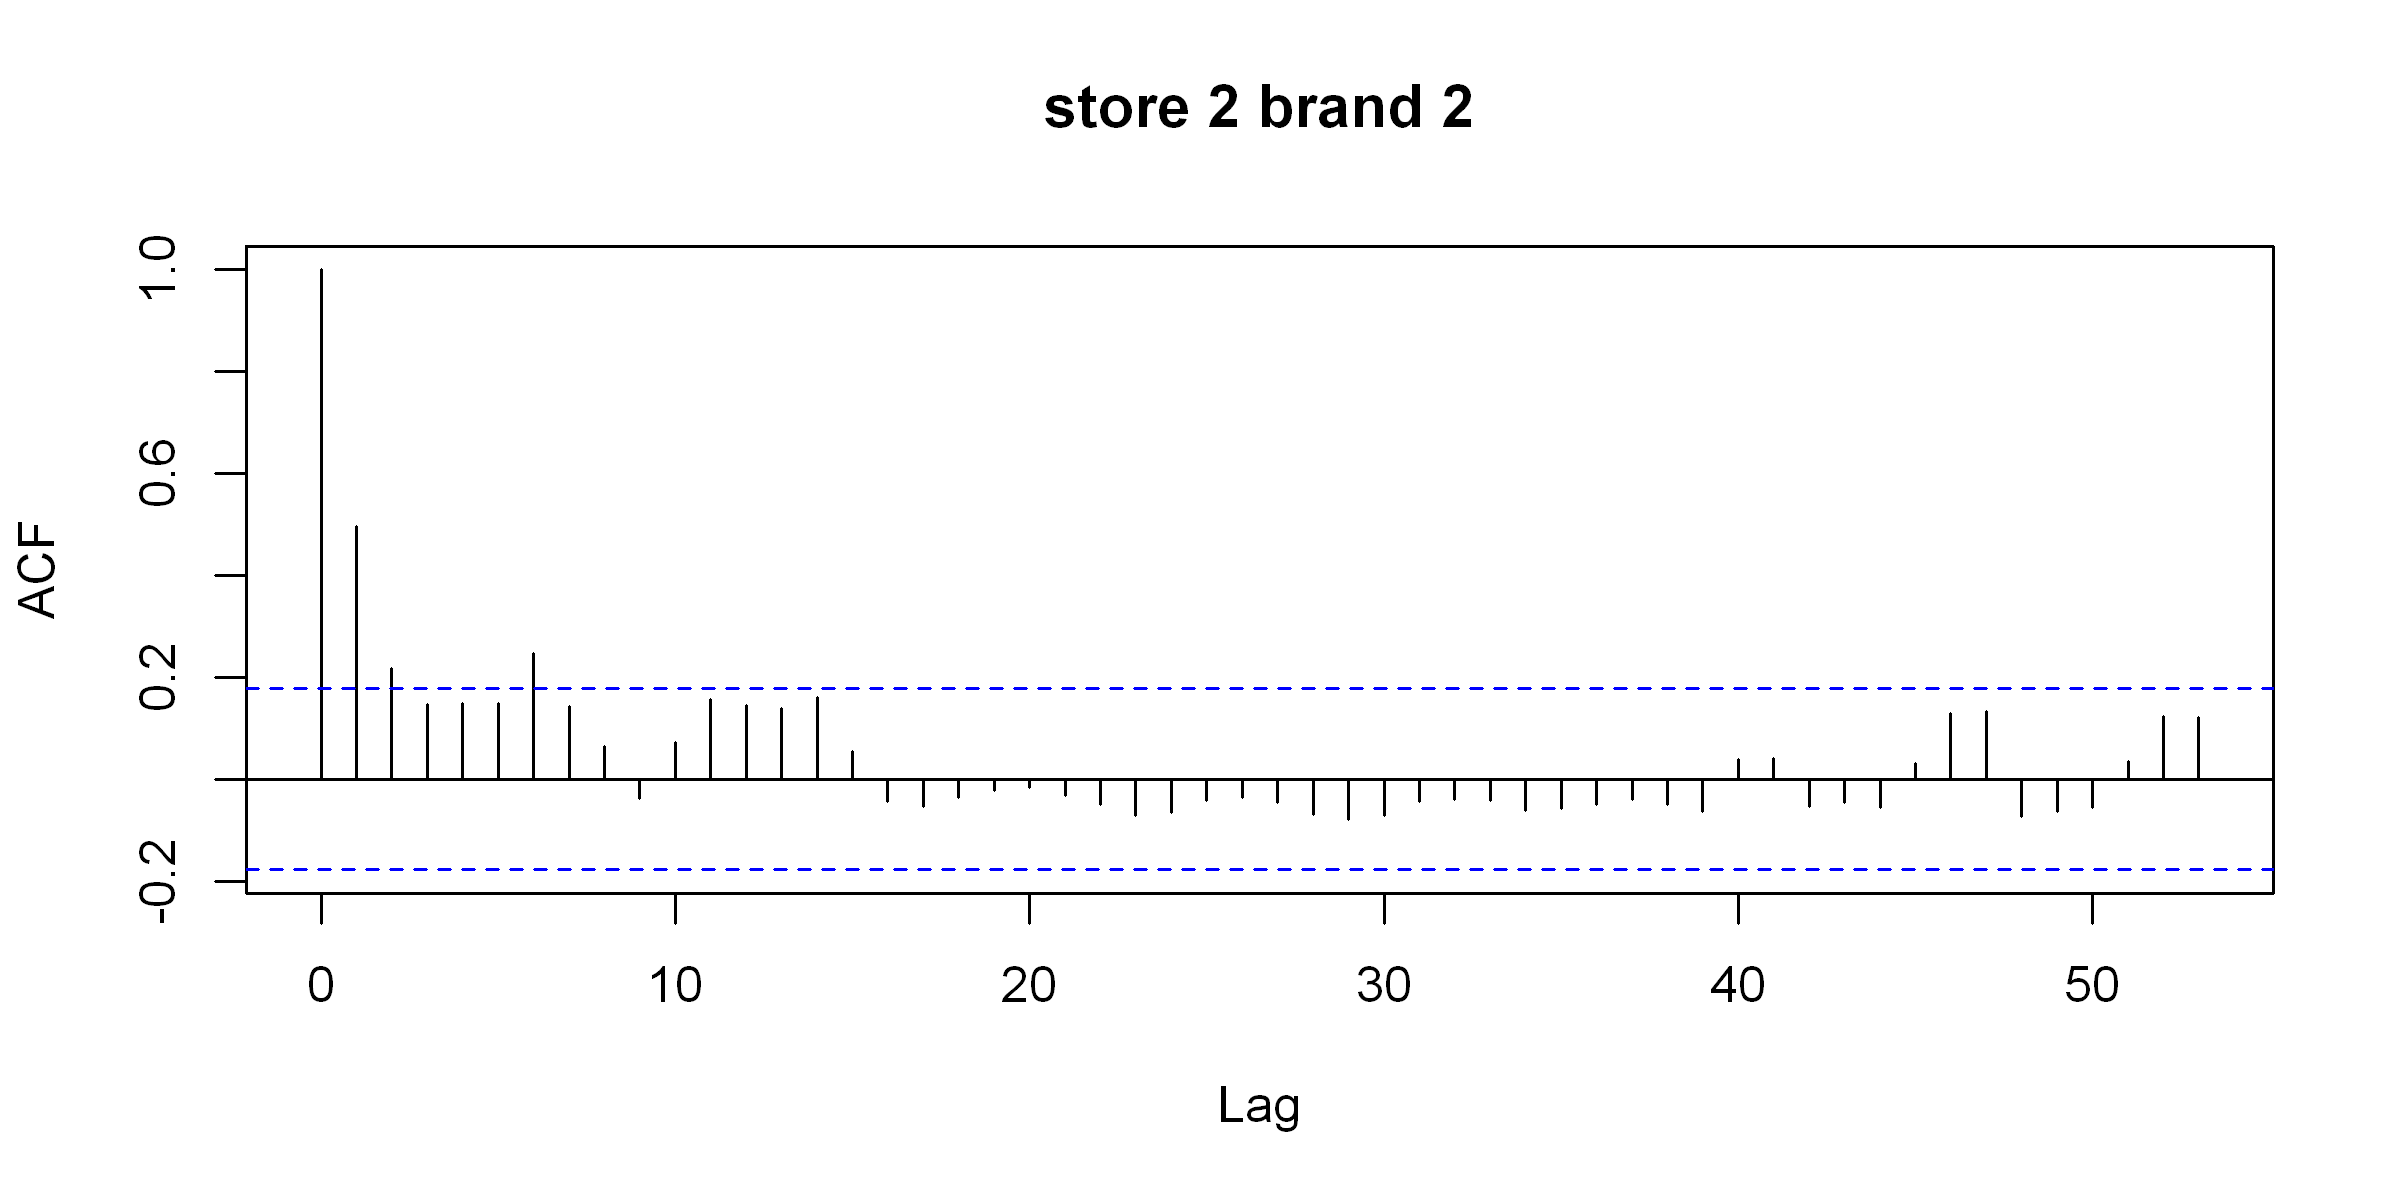

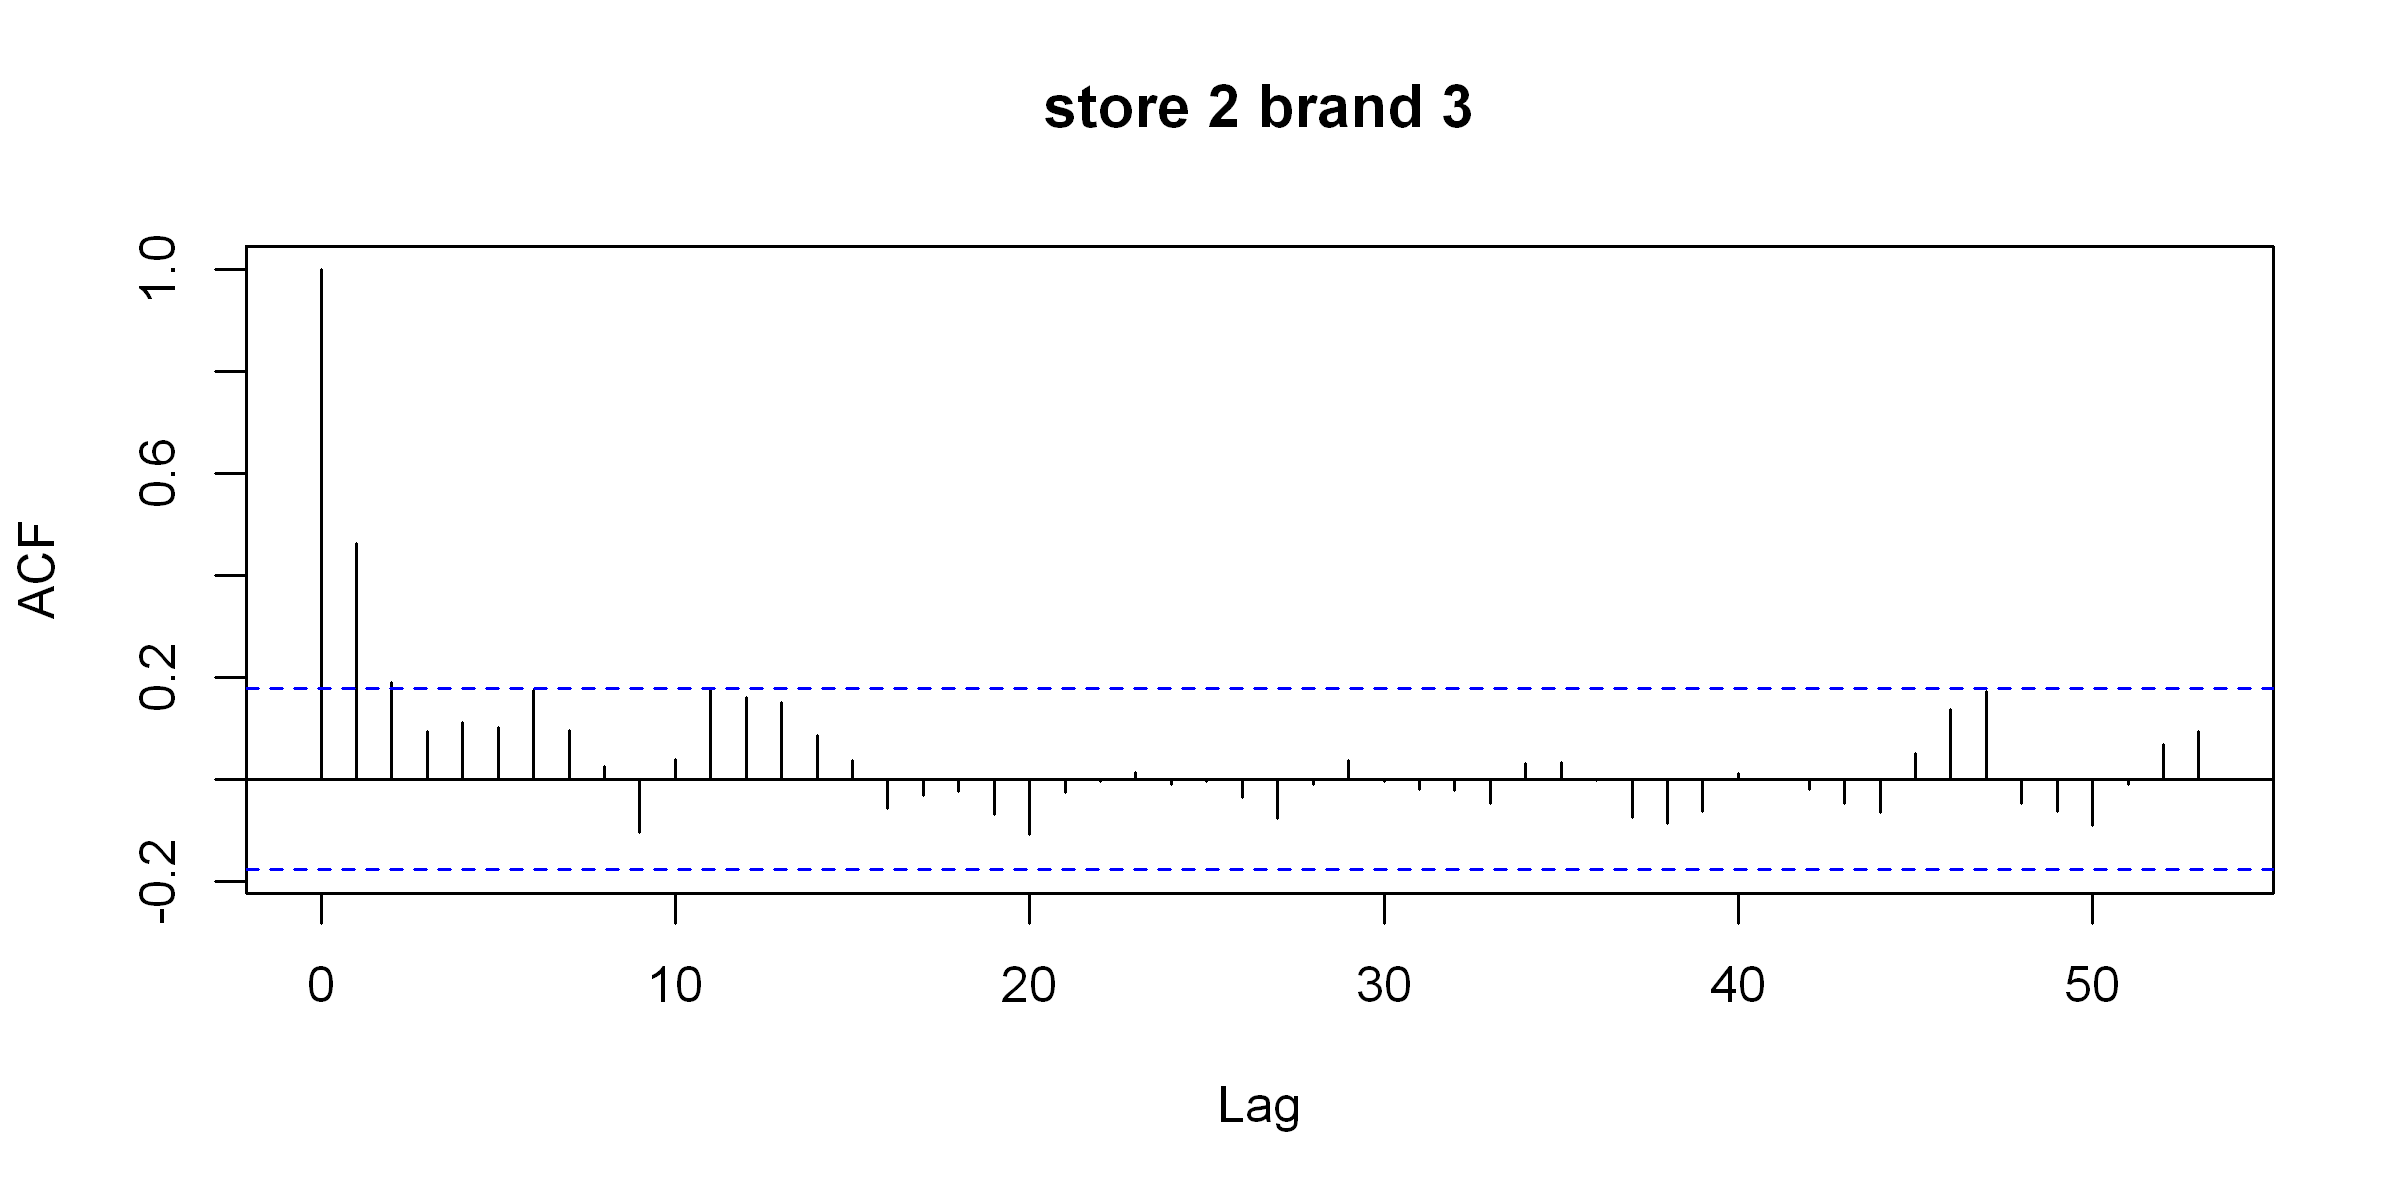

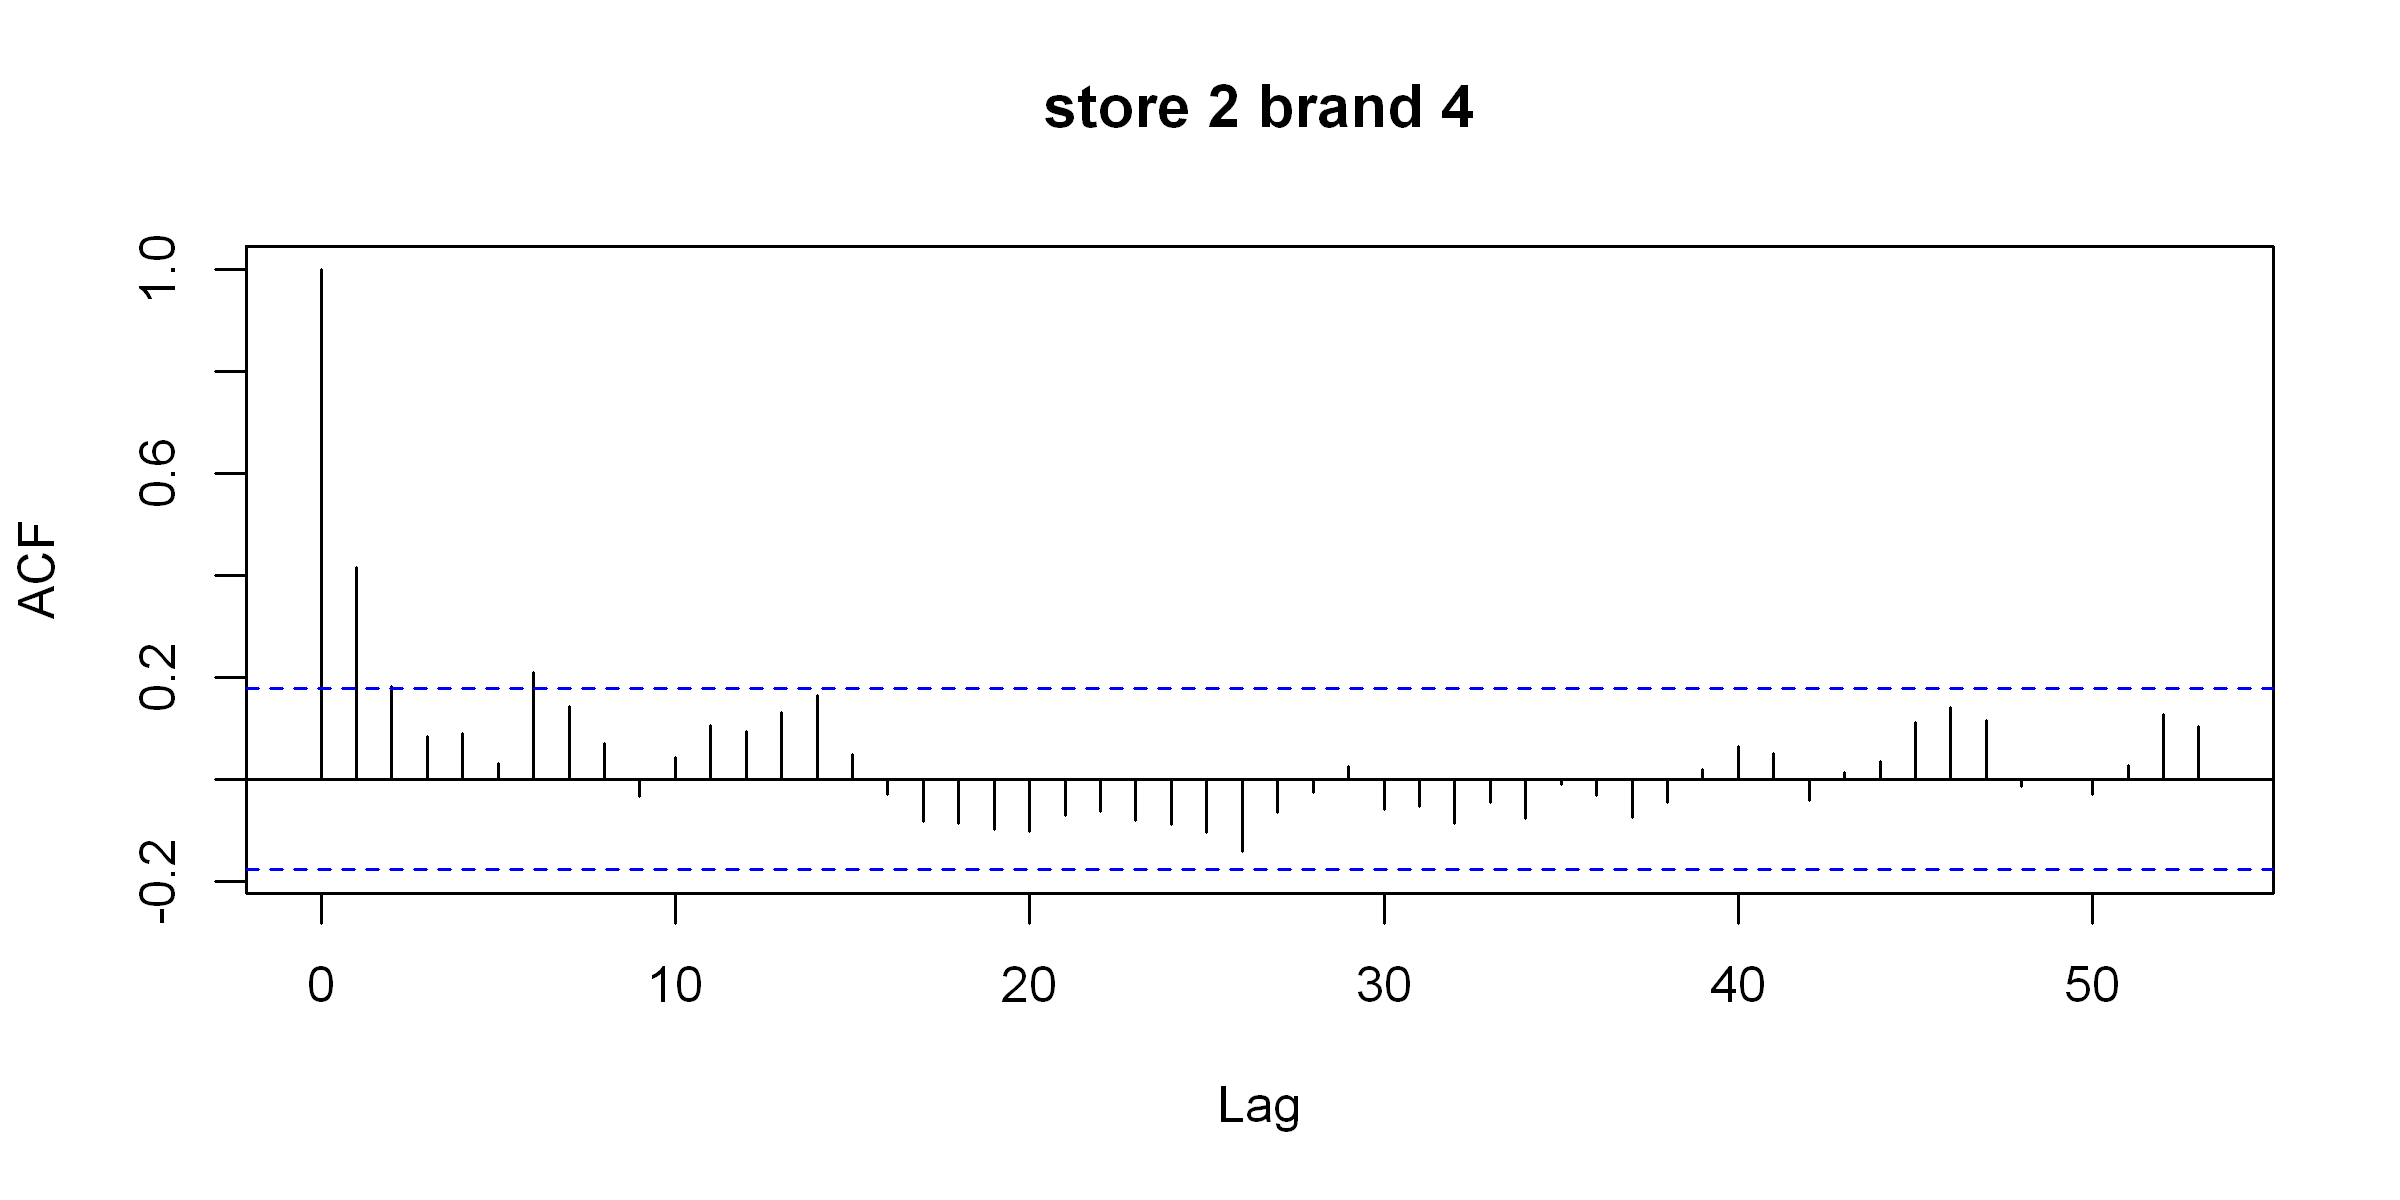

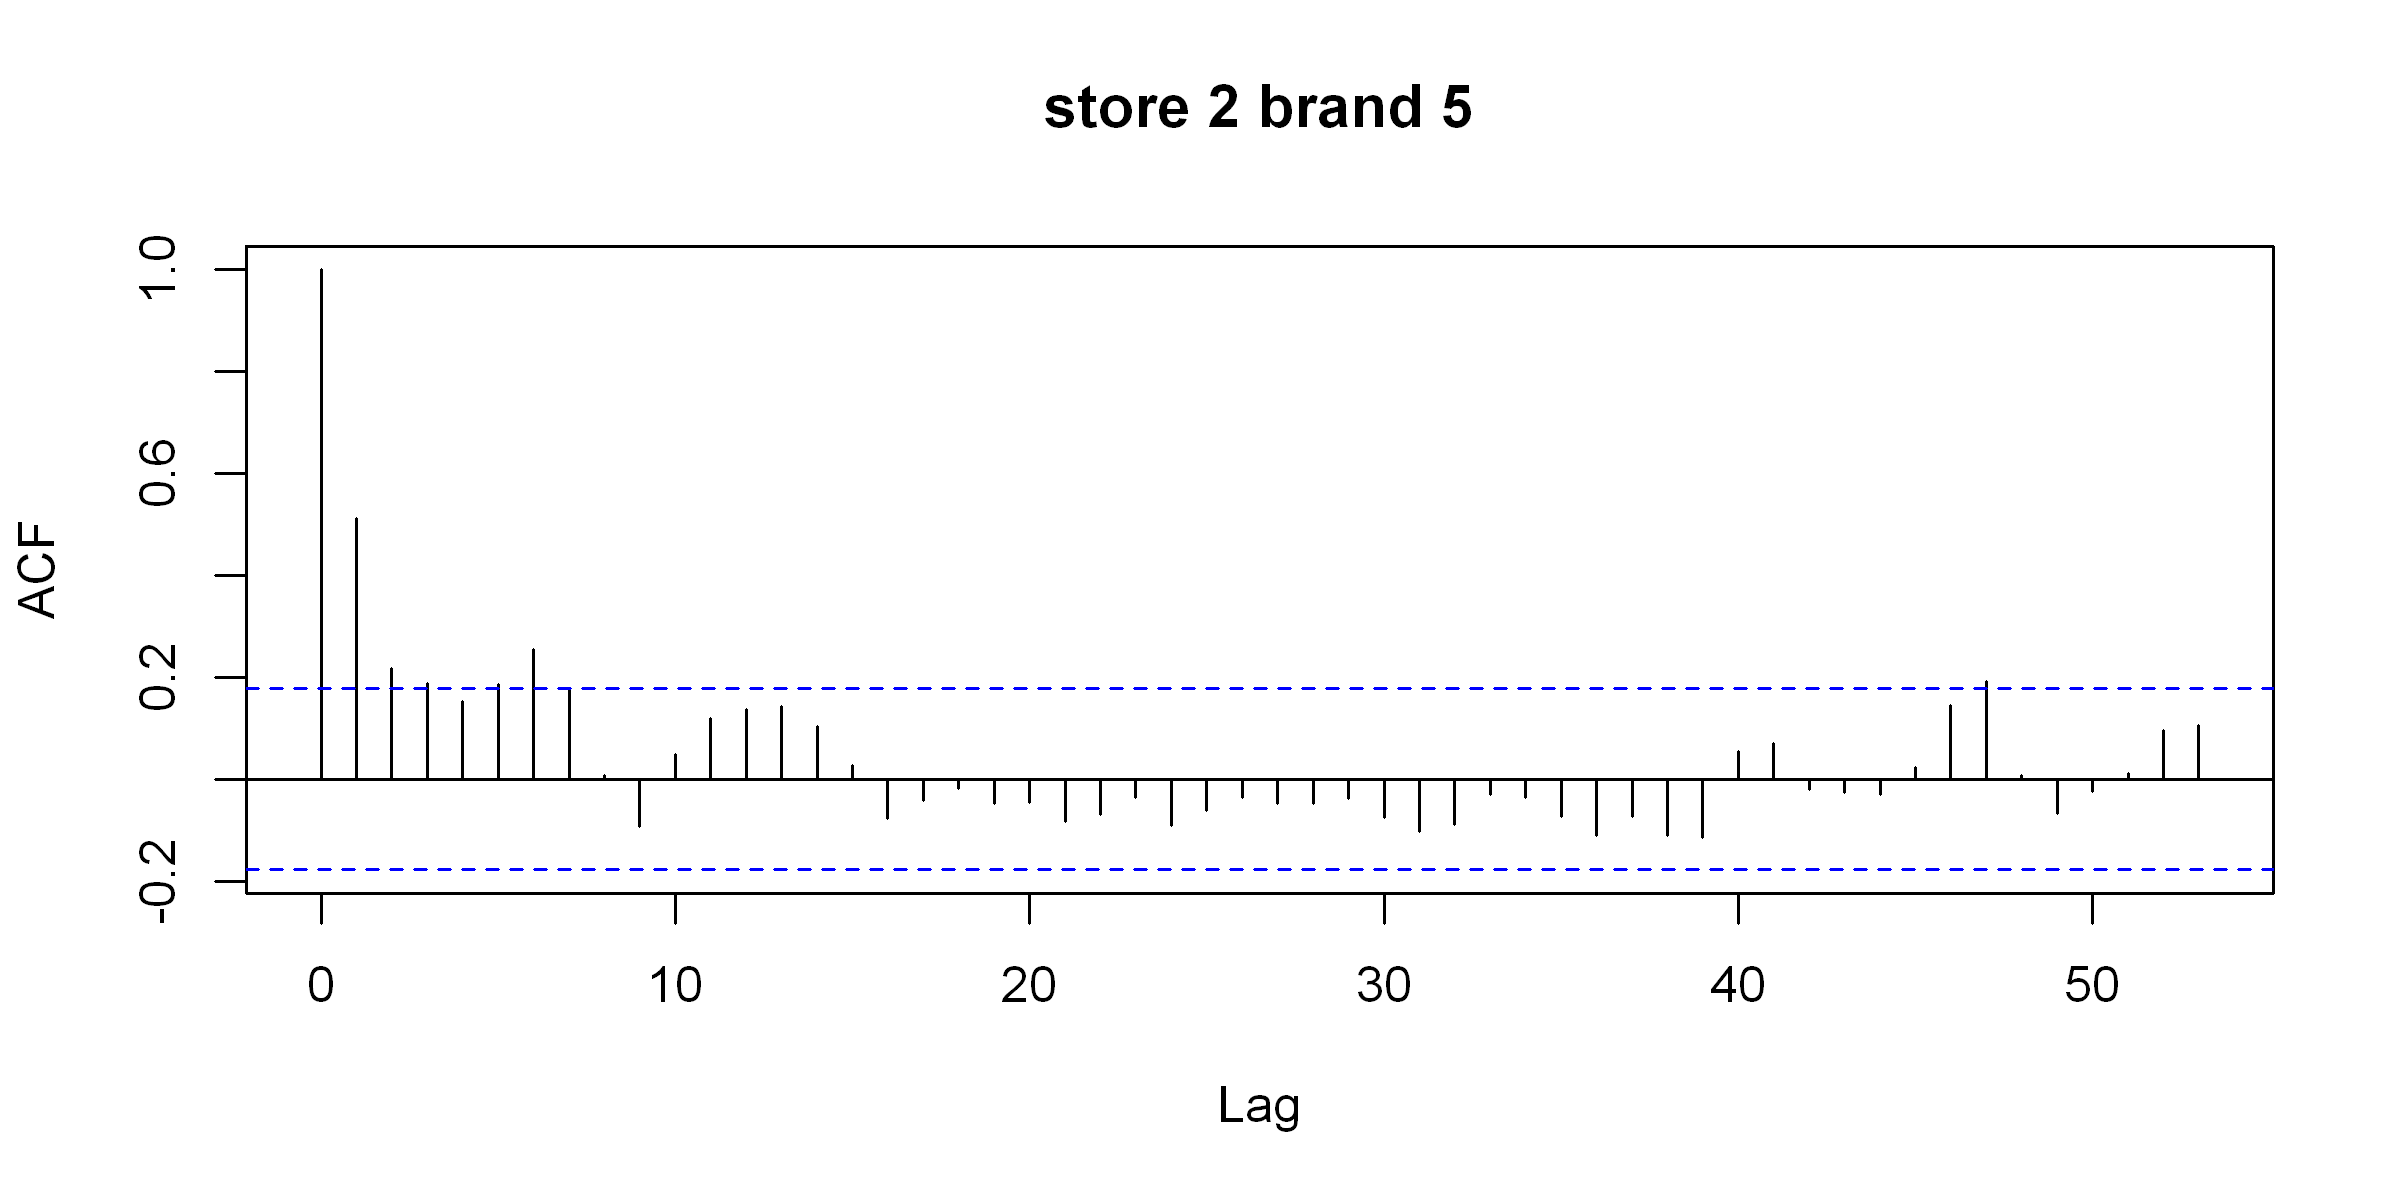

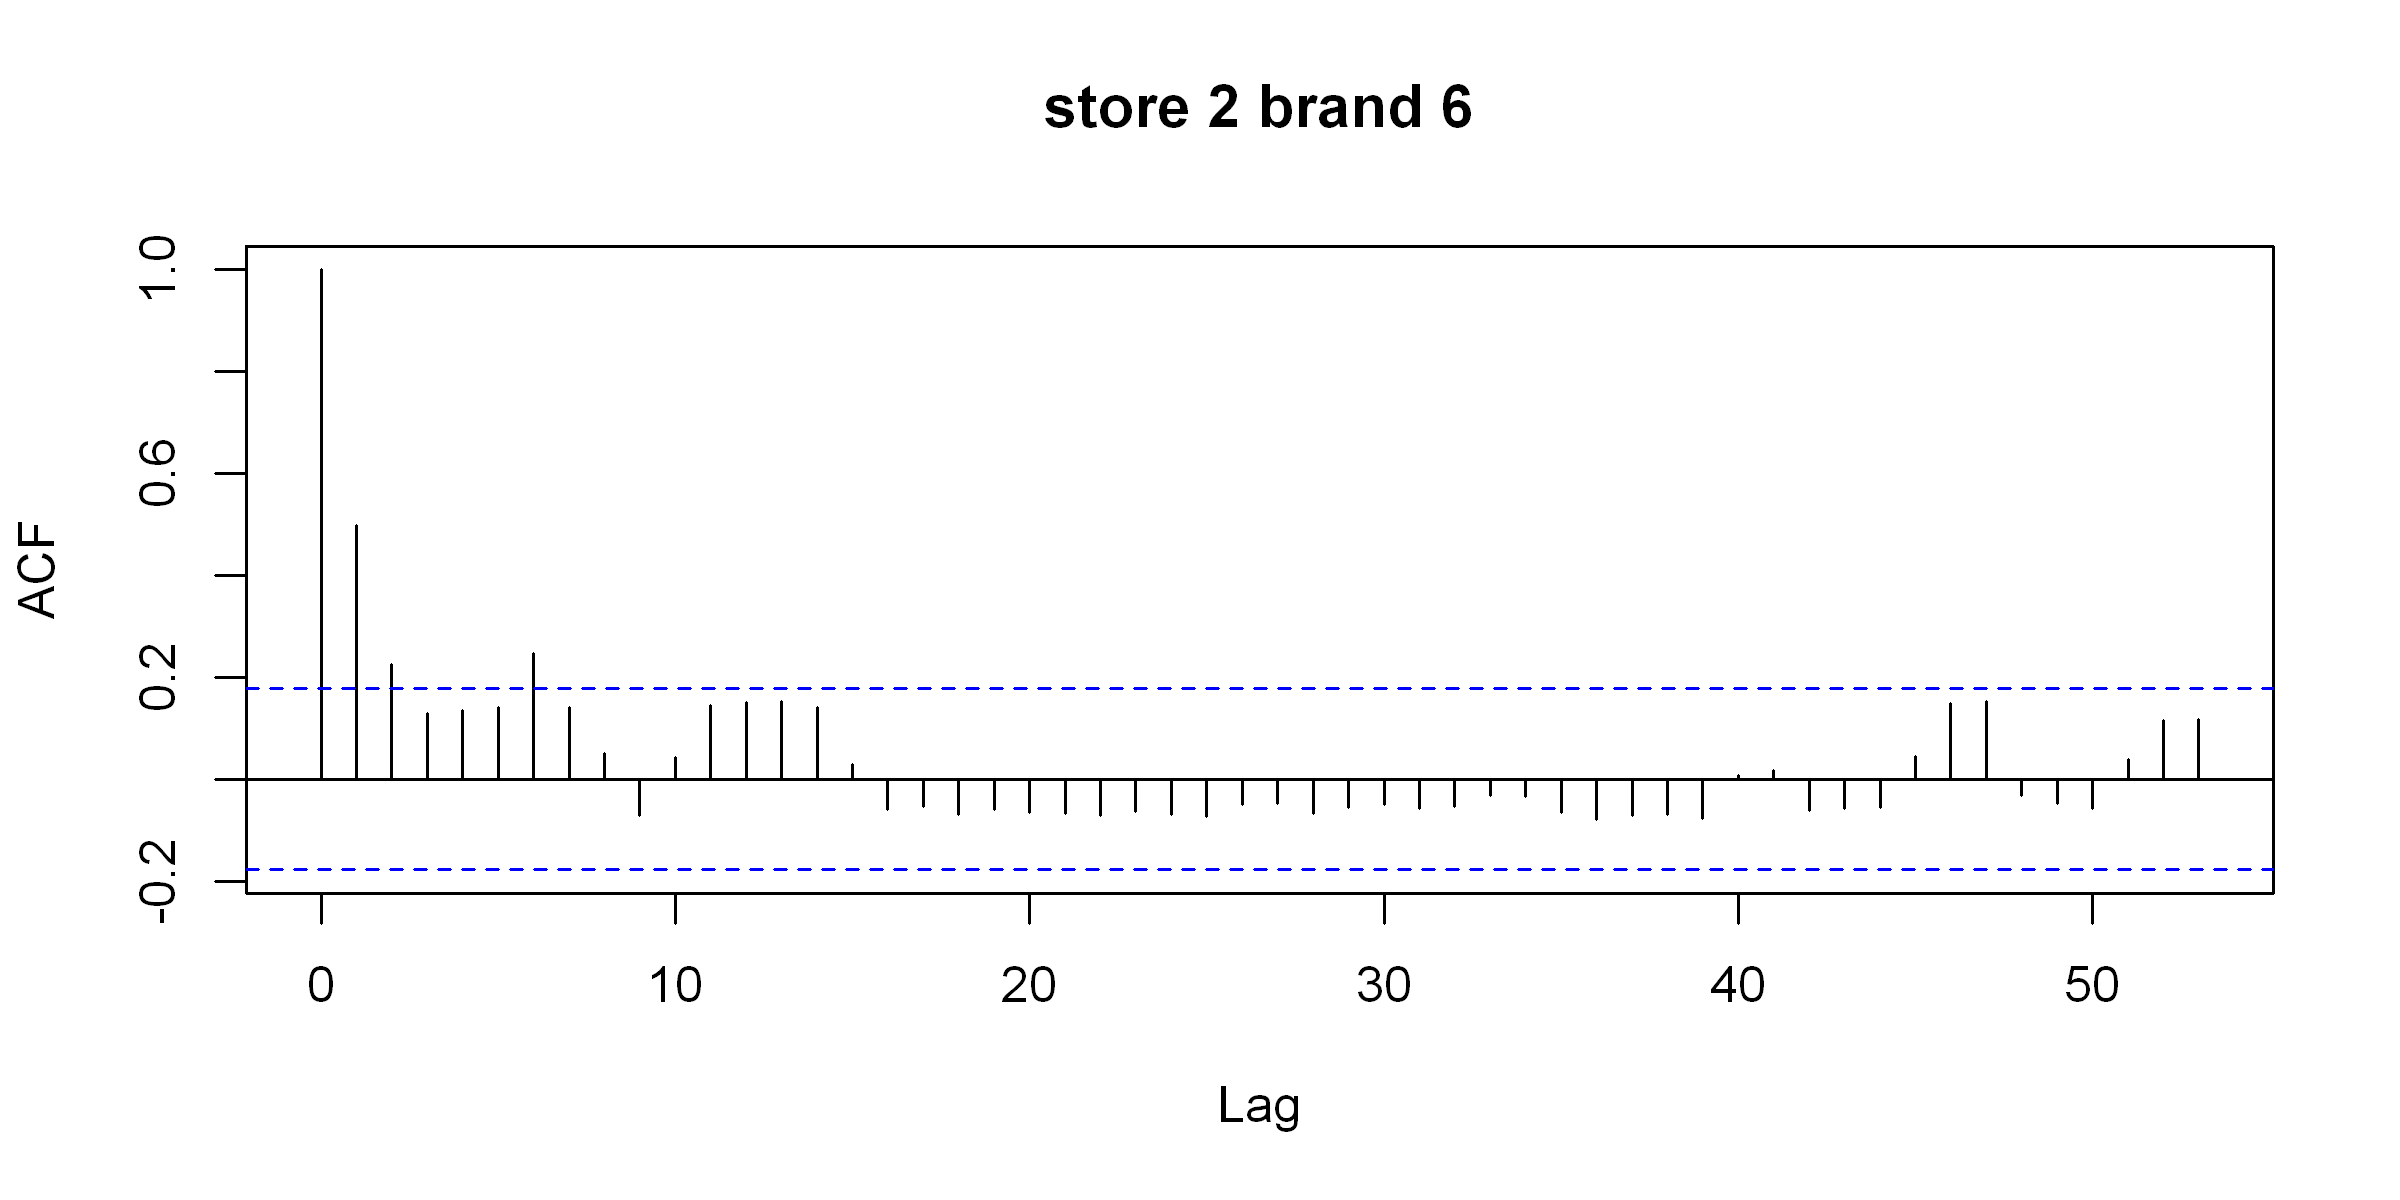

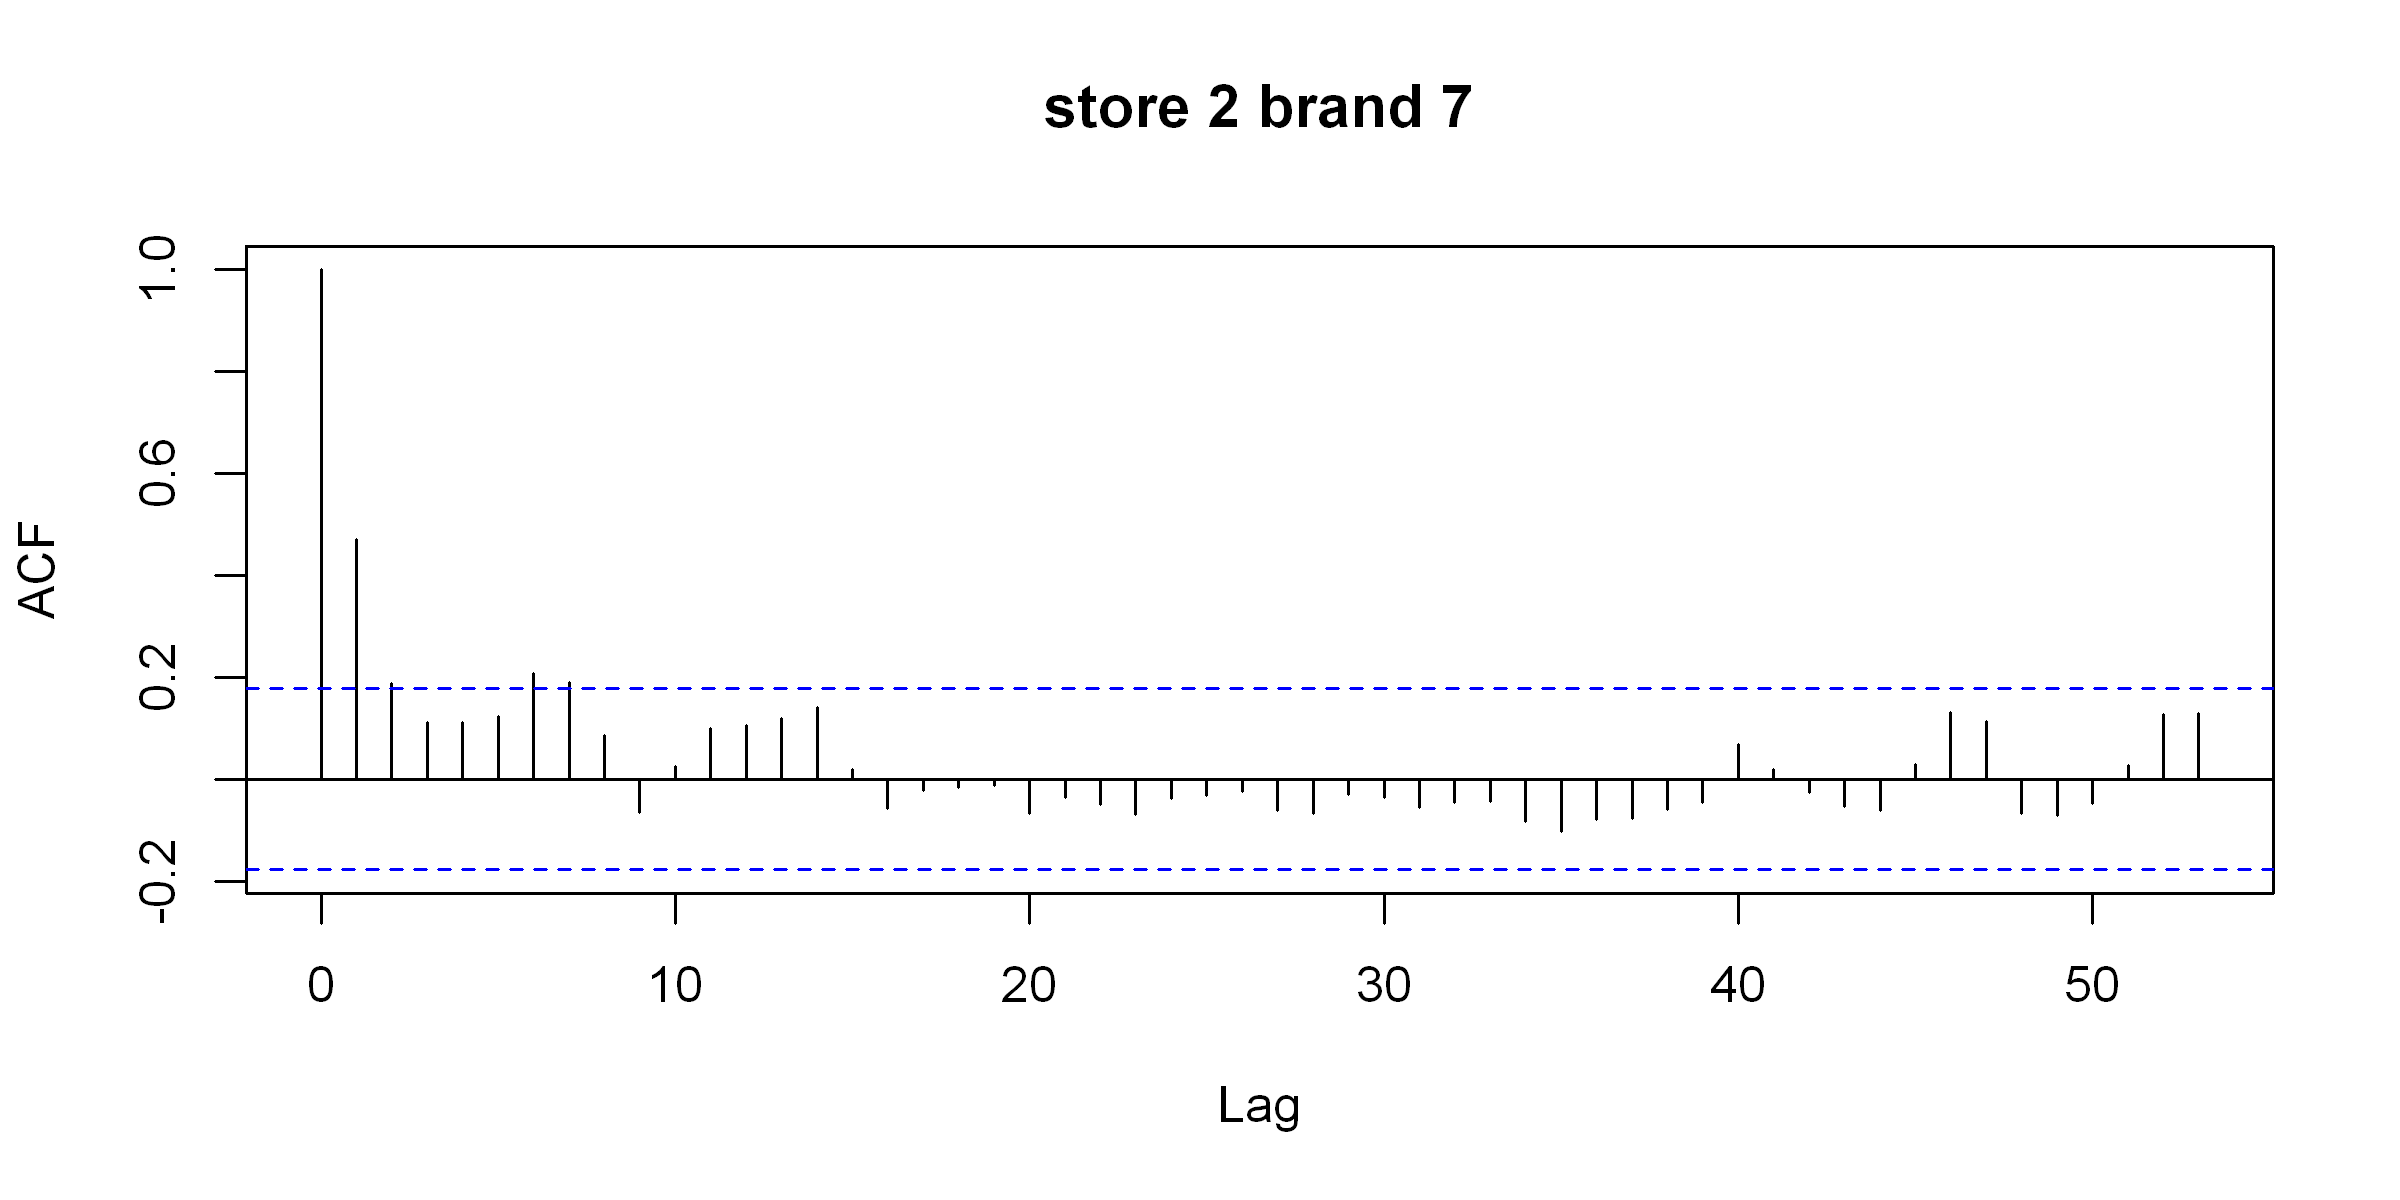

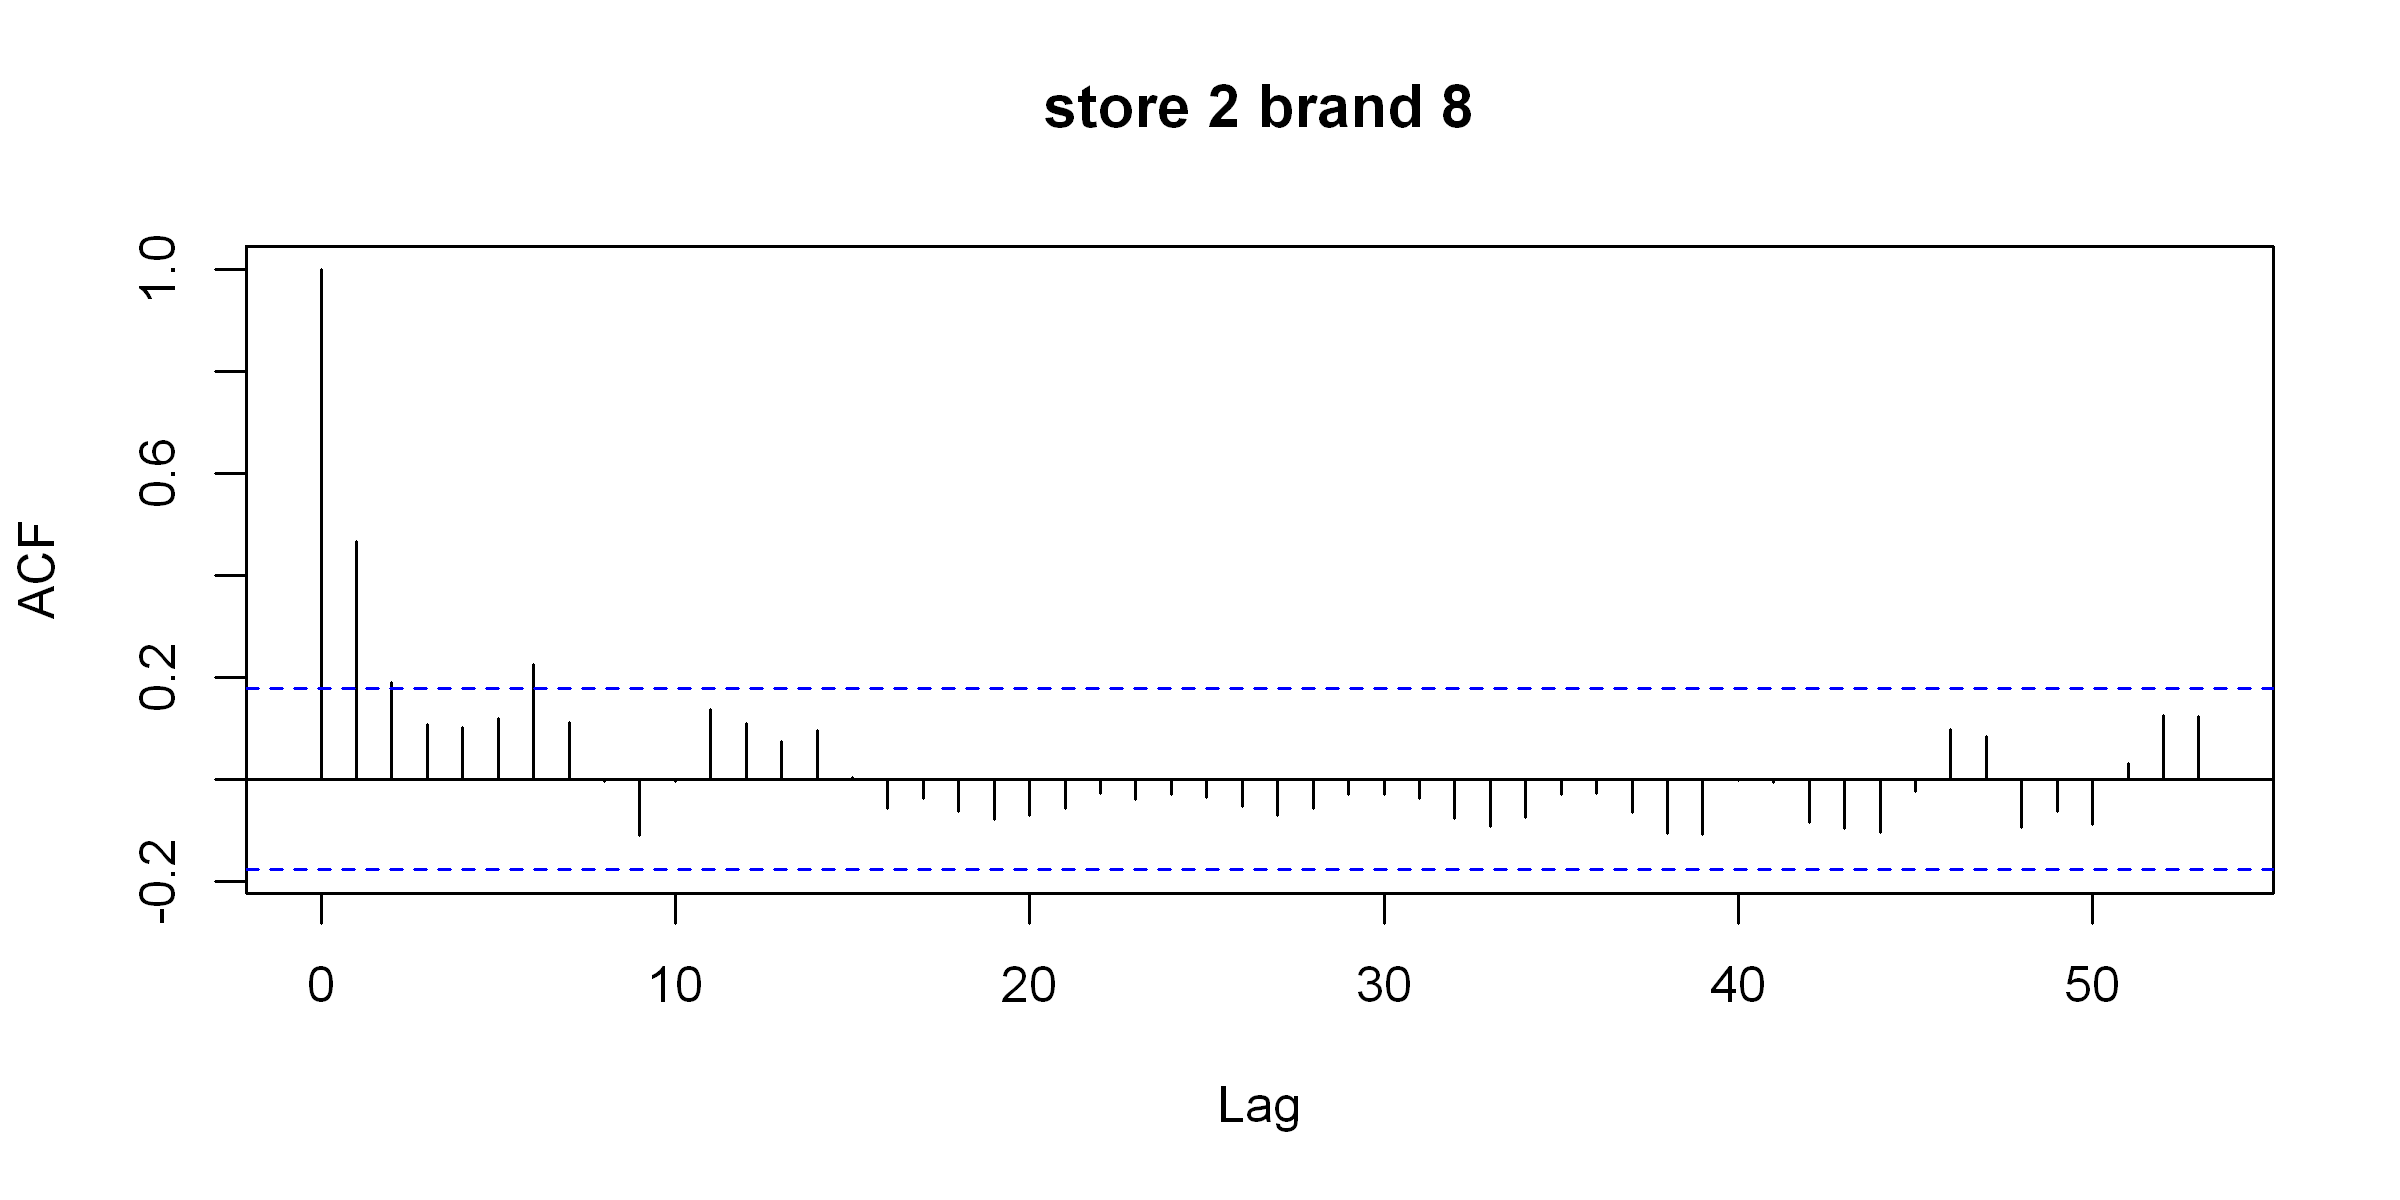

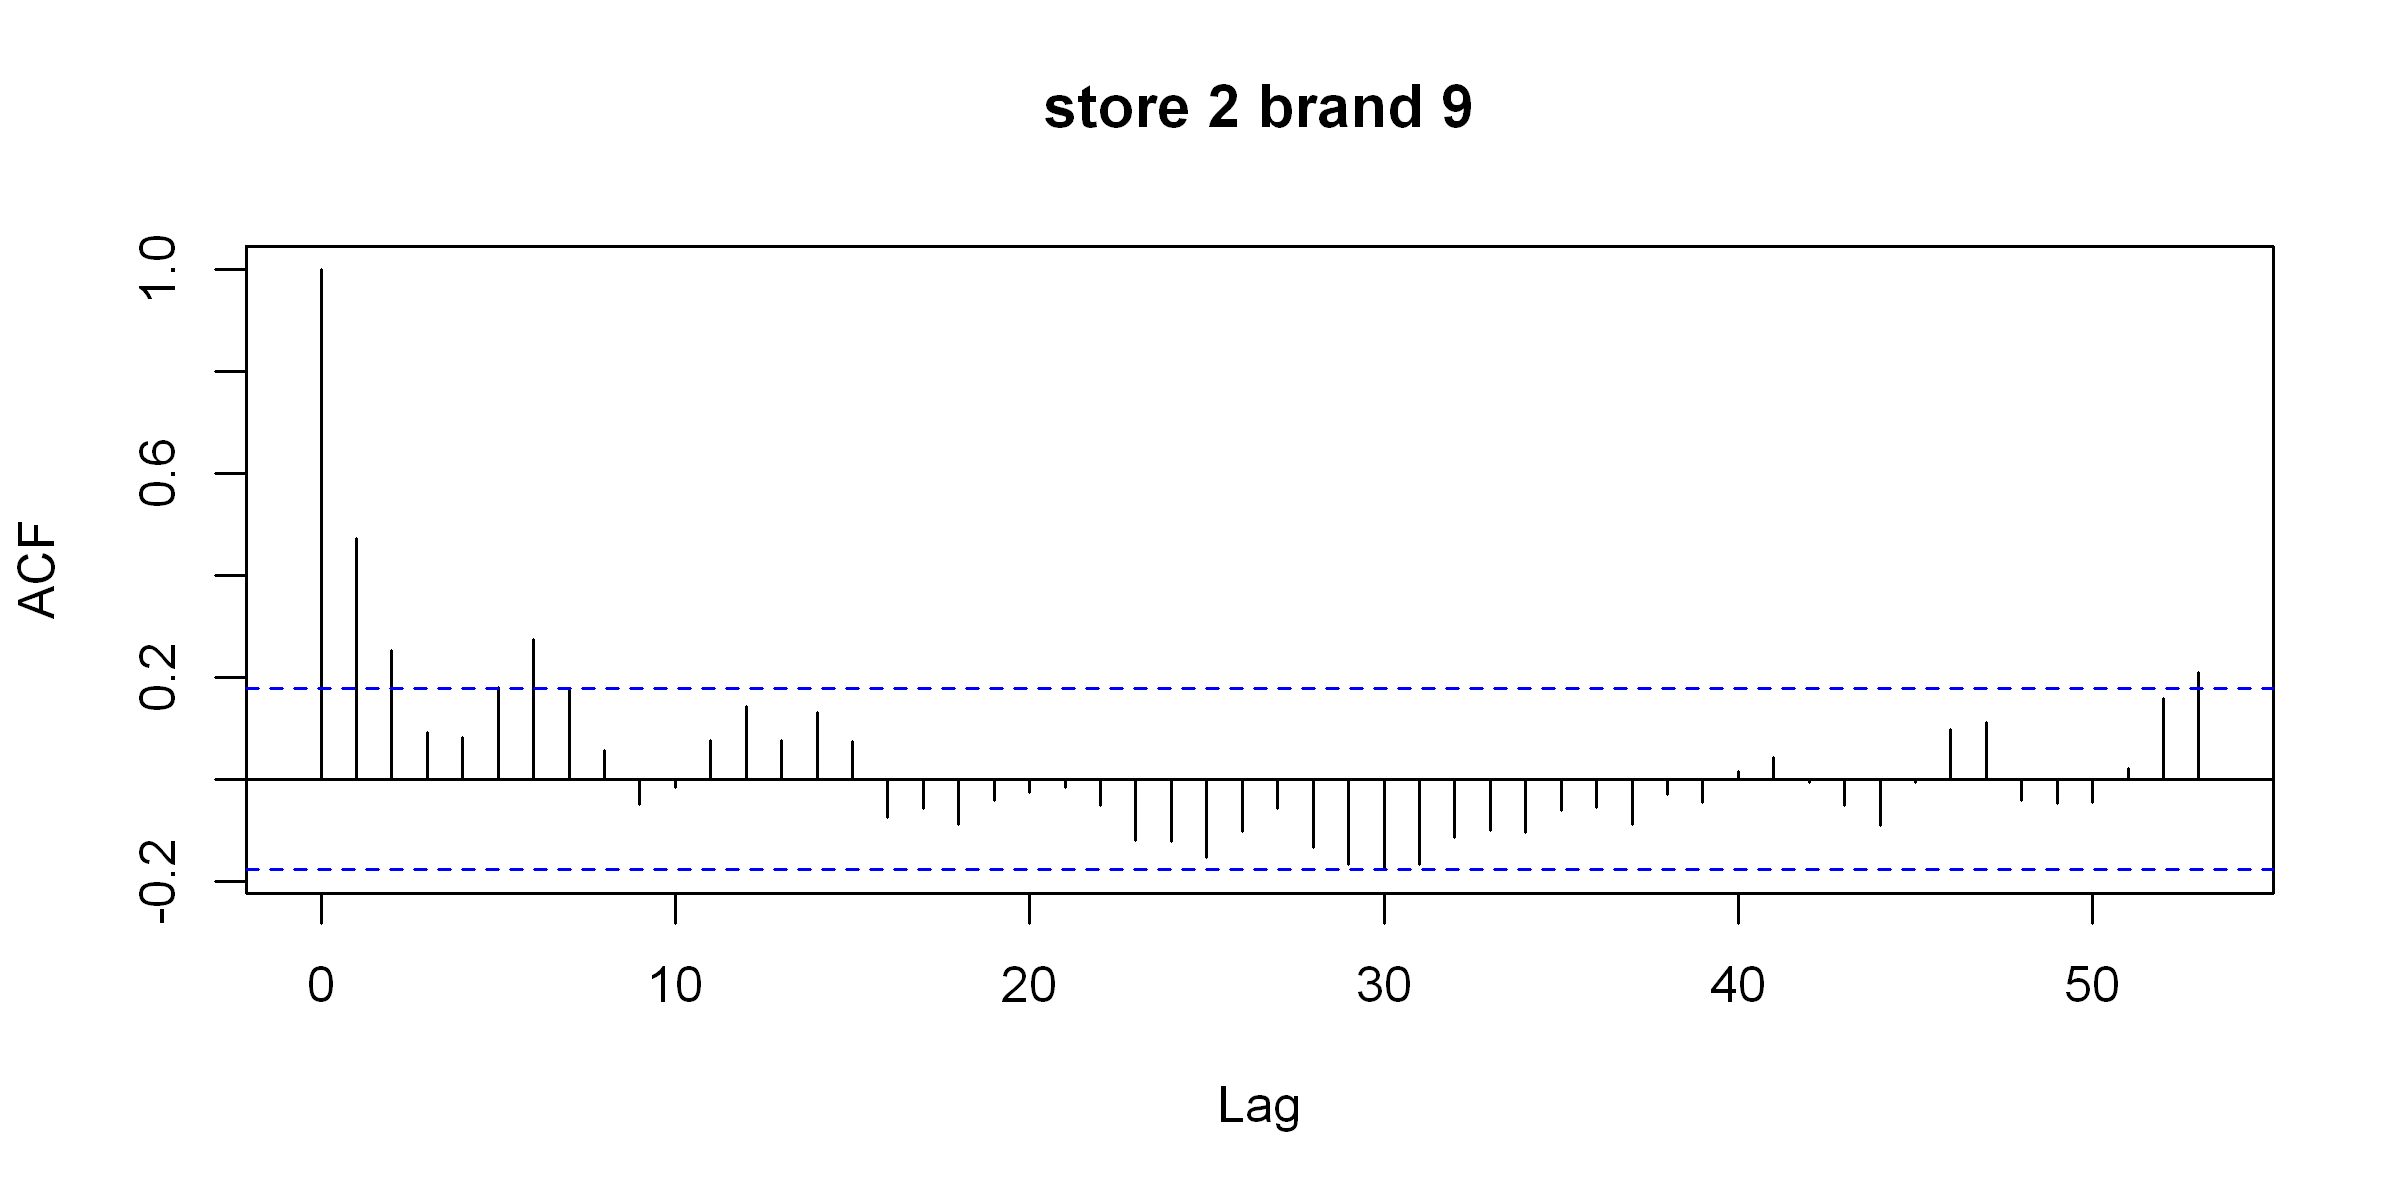

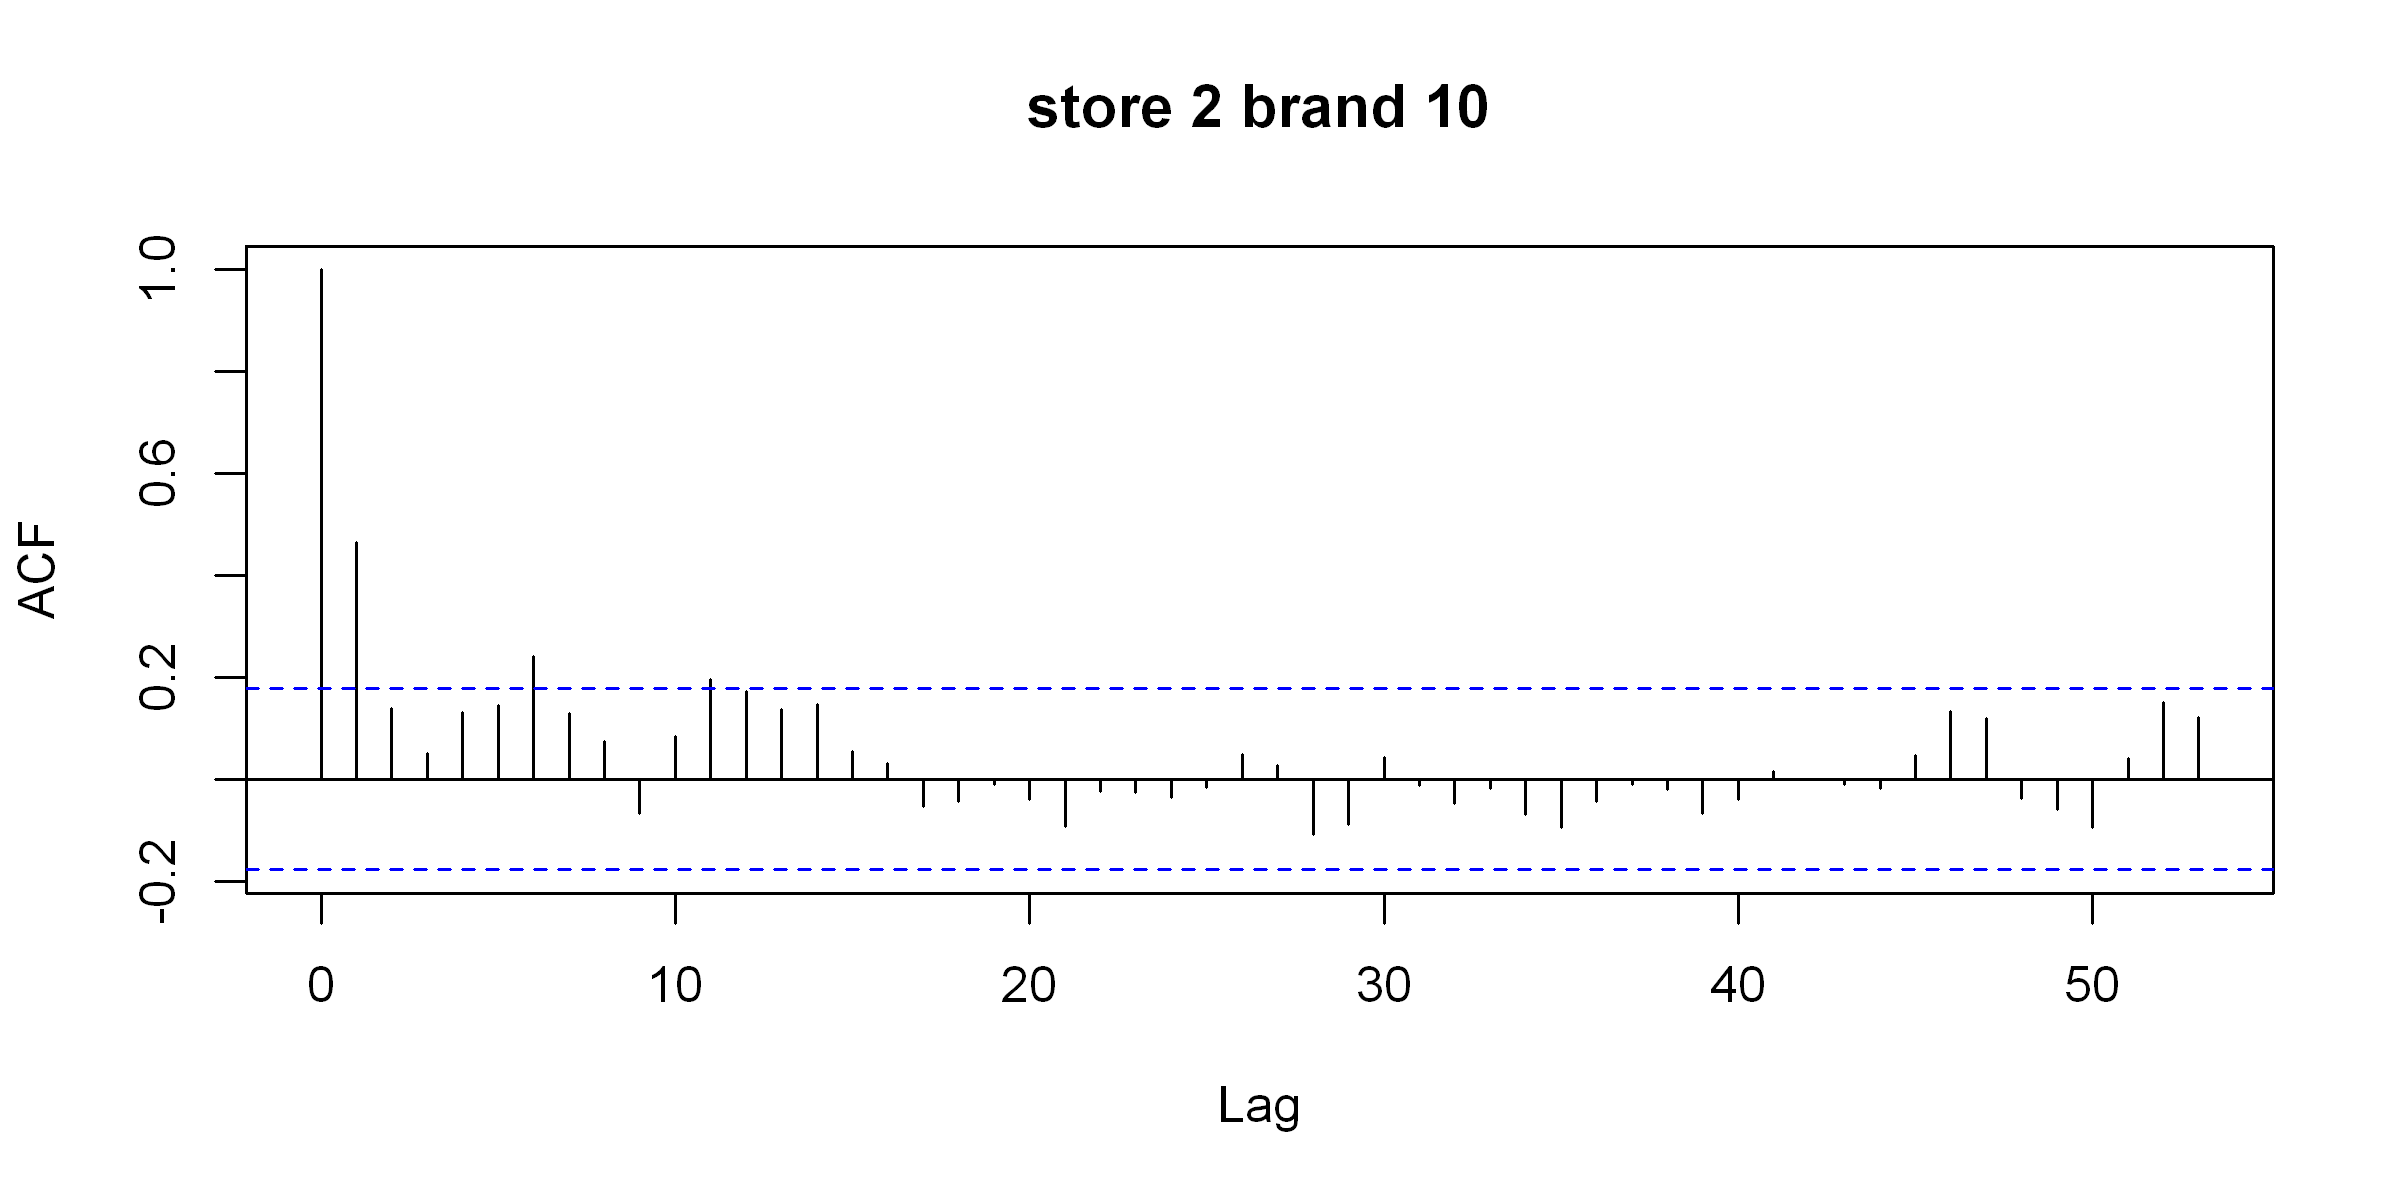

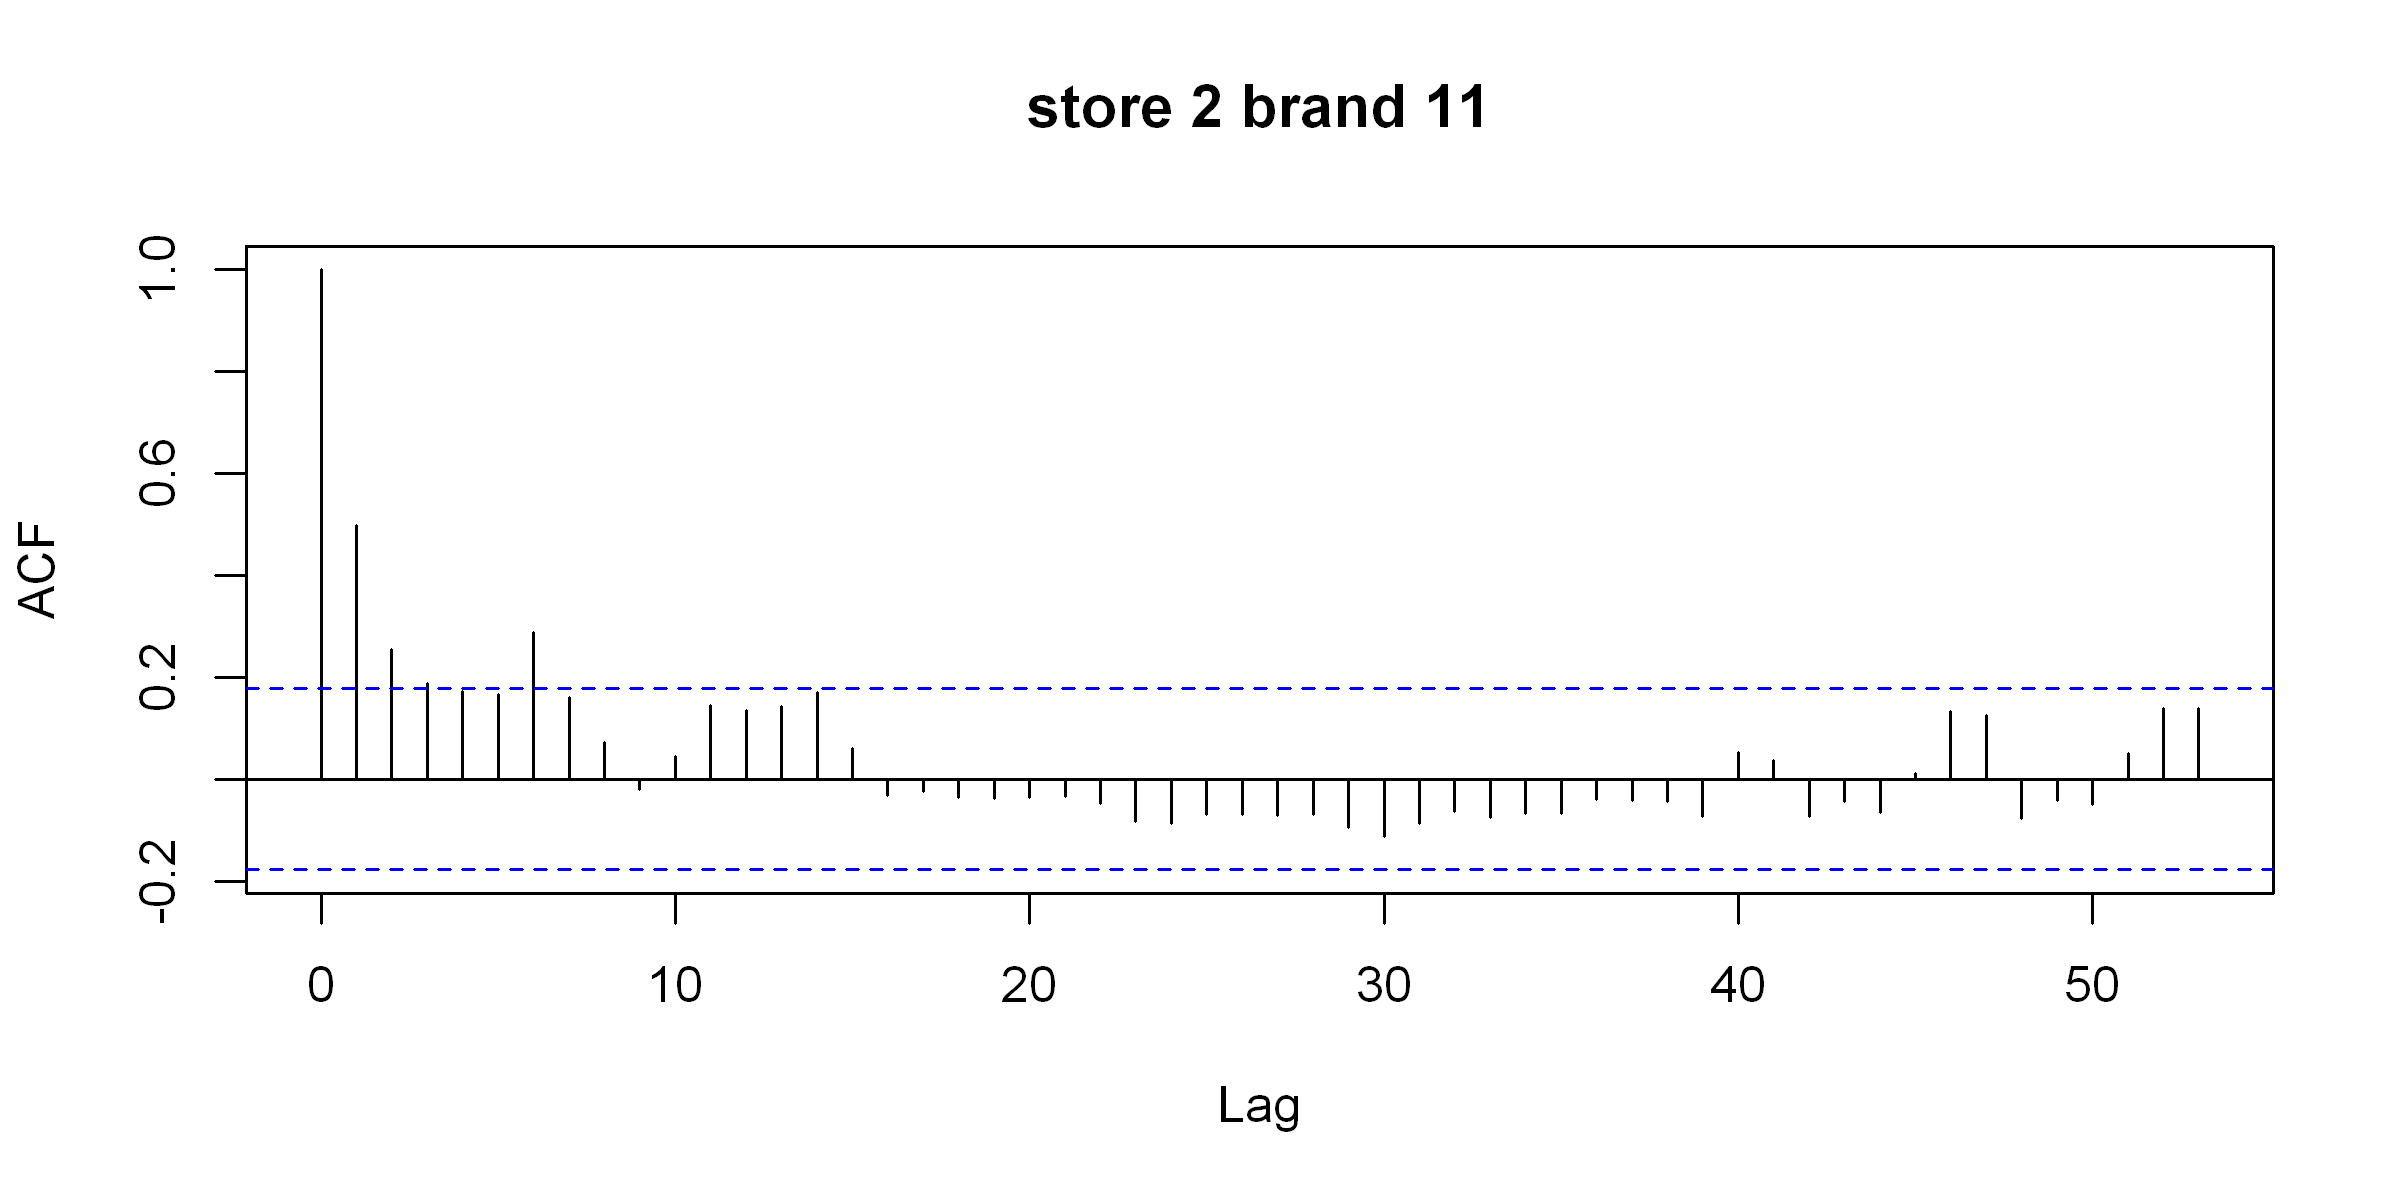

In [14]:
# Check autocorrelation
sample_store <- 2
lag_max <- 53
brand_list <- unique(sales$brand)
for (sample_brand in brand_list){
    sales_sub <- filter(sales, store == sample_store, brand == sample_brand)
    acf(sales_sub$logmove, lag.max=lag_max, main=paste0('store ', sample_store, ' brand ', sample_brand))
}

## Impact of deal information

We find that deal column has a very significant impact on sales. The impact of feat column also looks strong although the pattern shown in the scatter plot is a bit noisy.

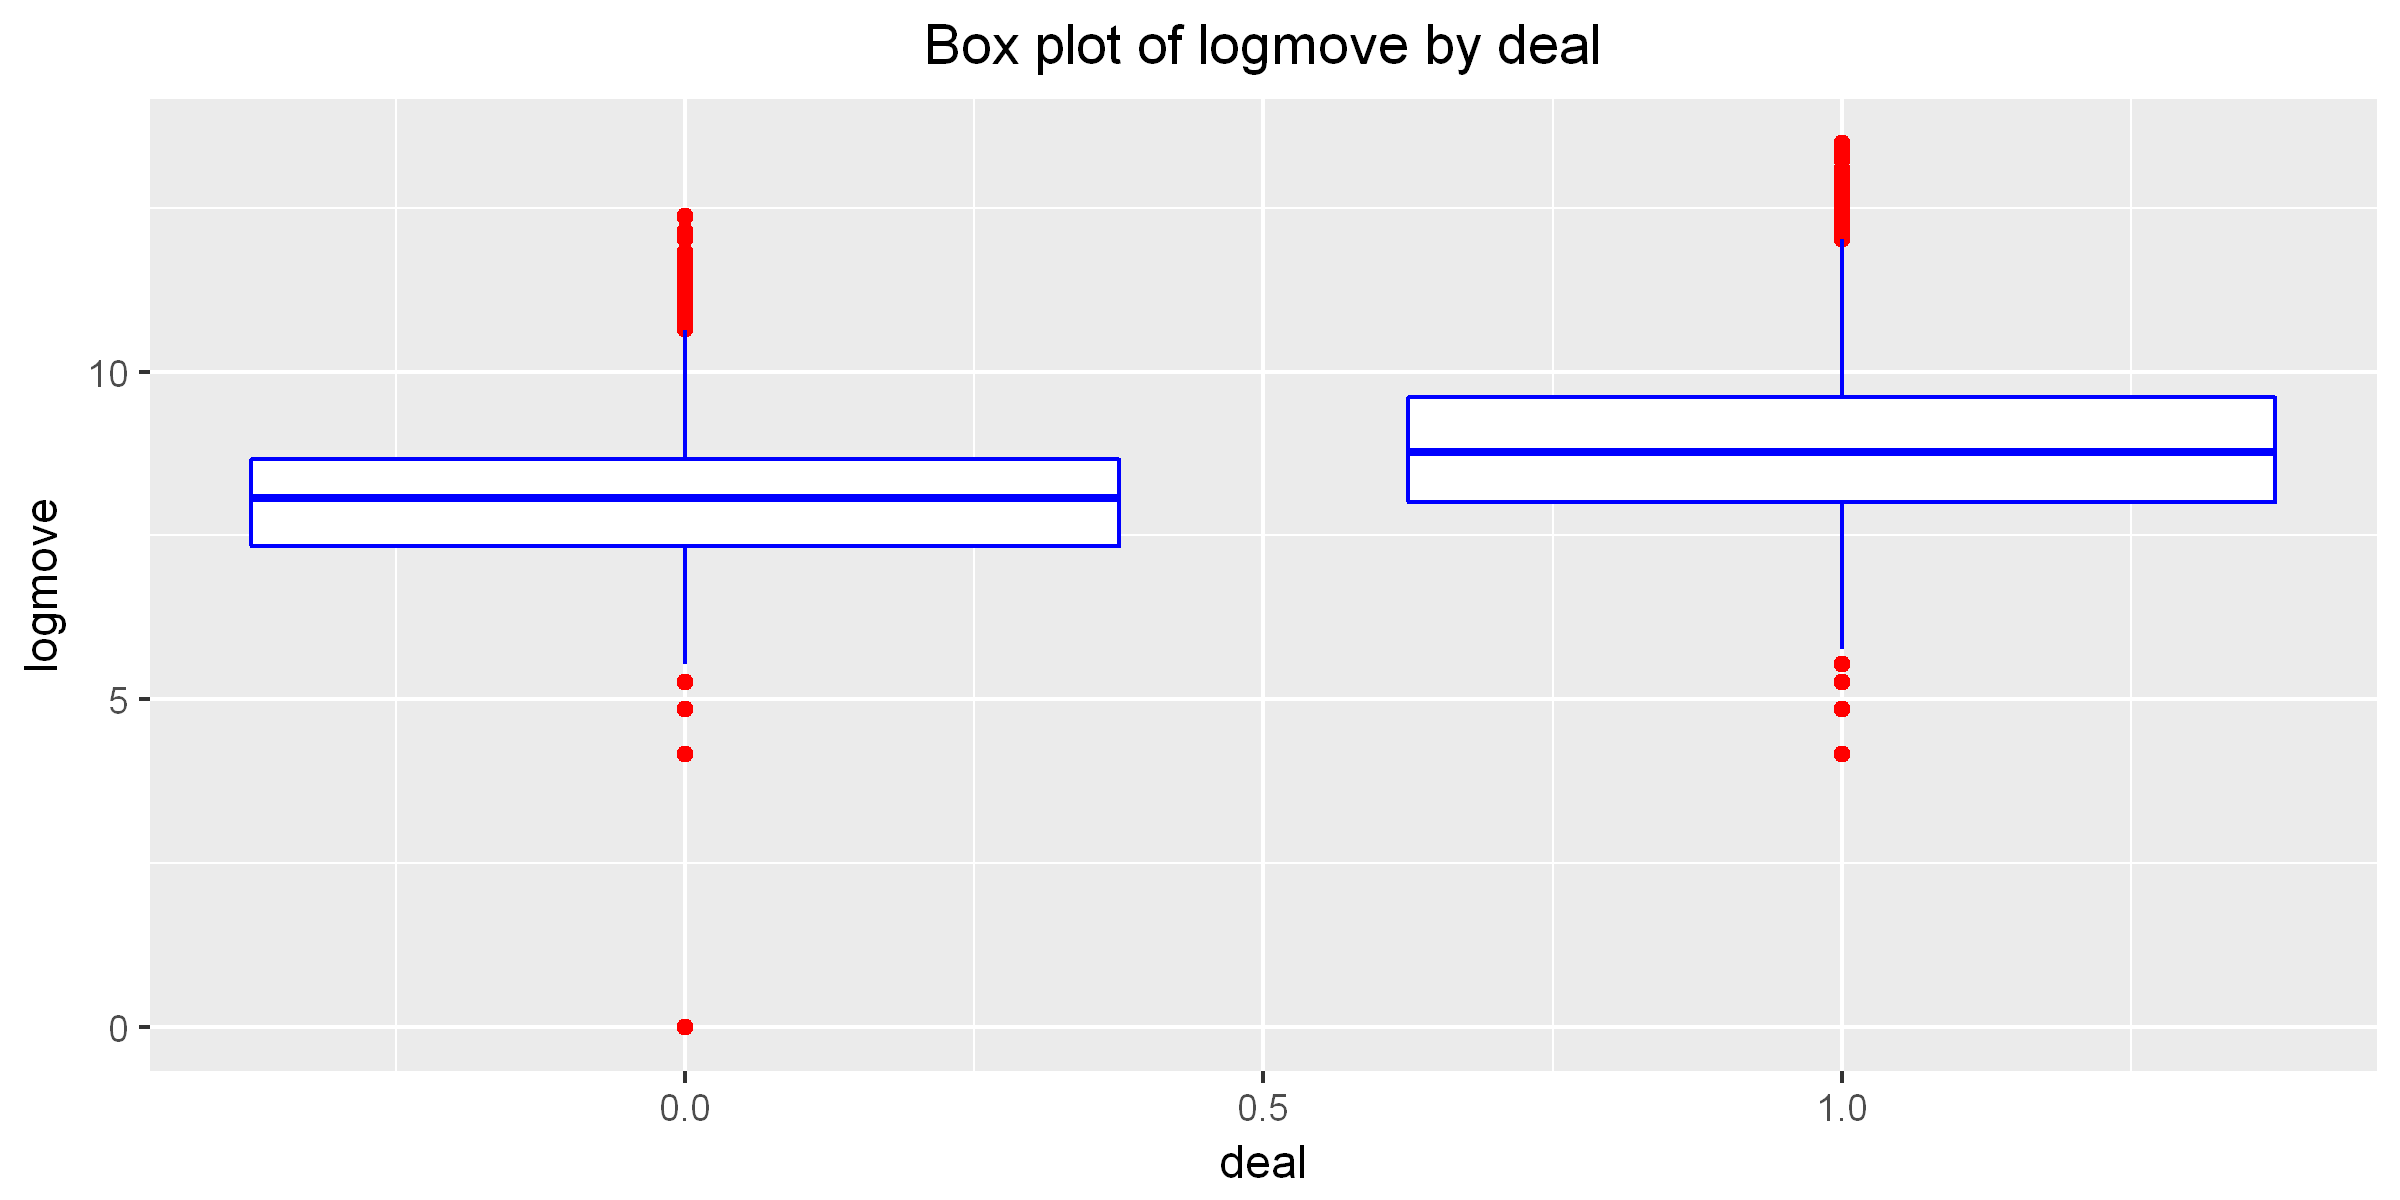

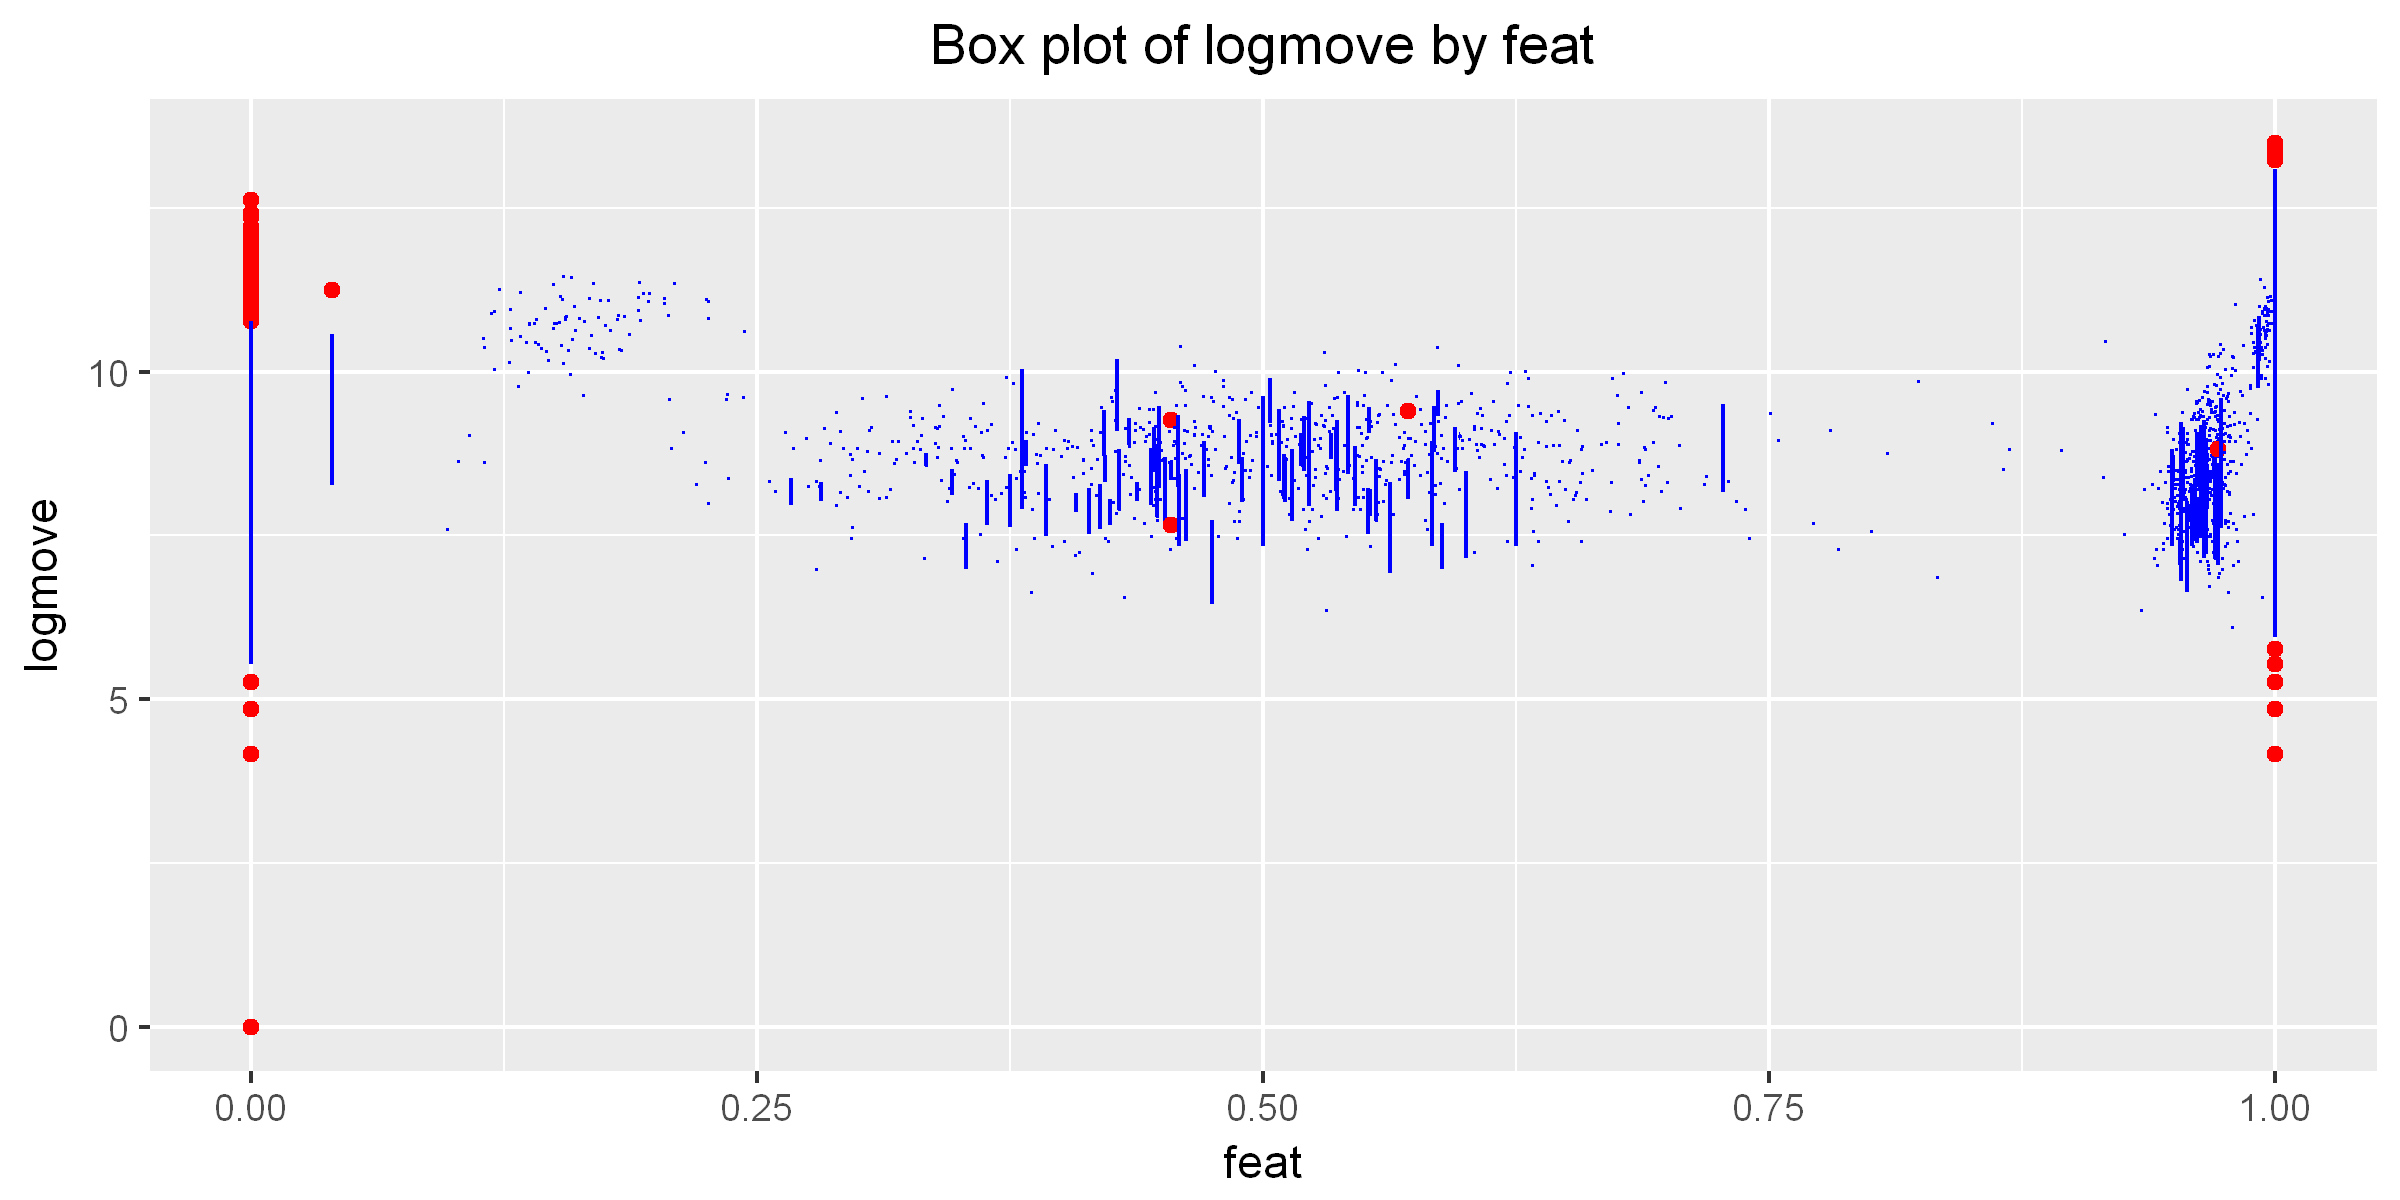

In [15]:
# Check the impact of deal, feat
# These two features significantly impact the sales
ggplot(sales, aes(x=deal, y=logmove, group=deal)) + geom_boxplot(color='blue', outlier.color='red') +
 ggtitle('Box plot of logmove by deal') +
 theme(plot.title = element_text(hjust = 0.5))
ggplot(sales, aes(x=feat, y=logmove, group=feat)) + geom_boxplot(color='blue', outlier.color='red') +
 ggtitle('Box plot of logmove by feat') +
 theme(plot.title = element_text(hjust = 0.5))

## Impact of price

We find that the sales does typically decrease when the absolute price or the relative price of the product increases.

In [16]:
# Check the impact of price
sales['price'] <- apply(sales, 1, function(x) x[paste0('price', x['brand'])])
price_cols <- c('price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 
                'price9', 'price10', 'price11')
sales['avg_price'] <- apply(select(sales, price_cols), 1, function(x) mean(x))
sales['price_ratio'] <- apply(sales, 1, function(x) if(x['avg_price']>0) x['price']/x['avg_price'] else 0)

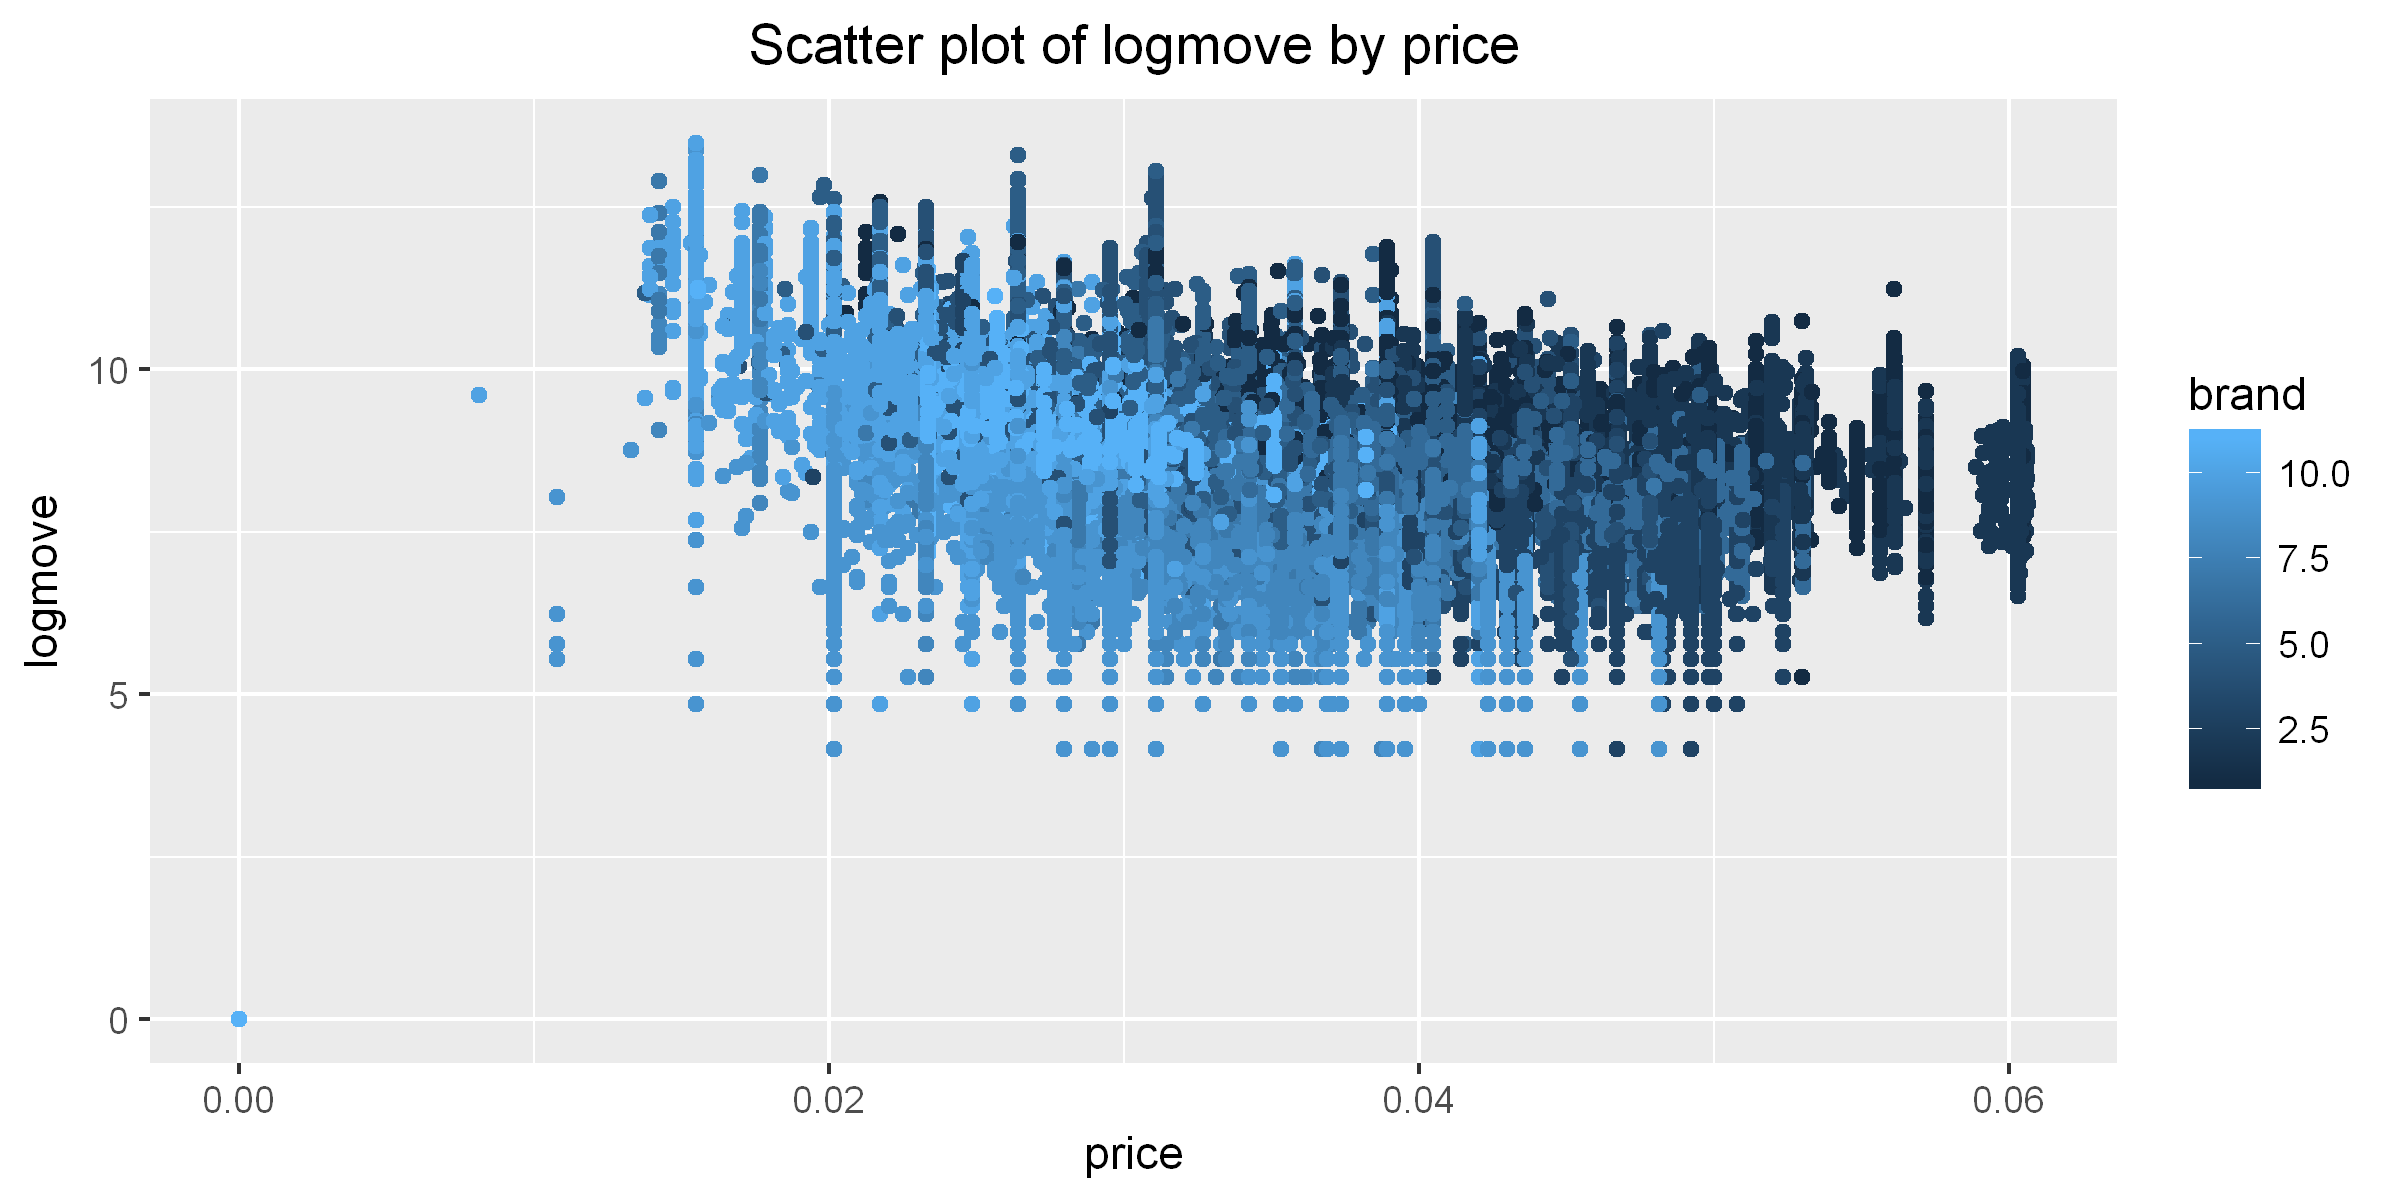

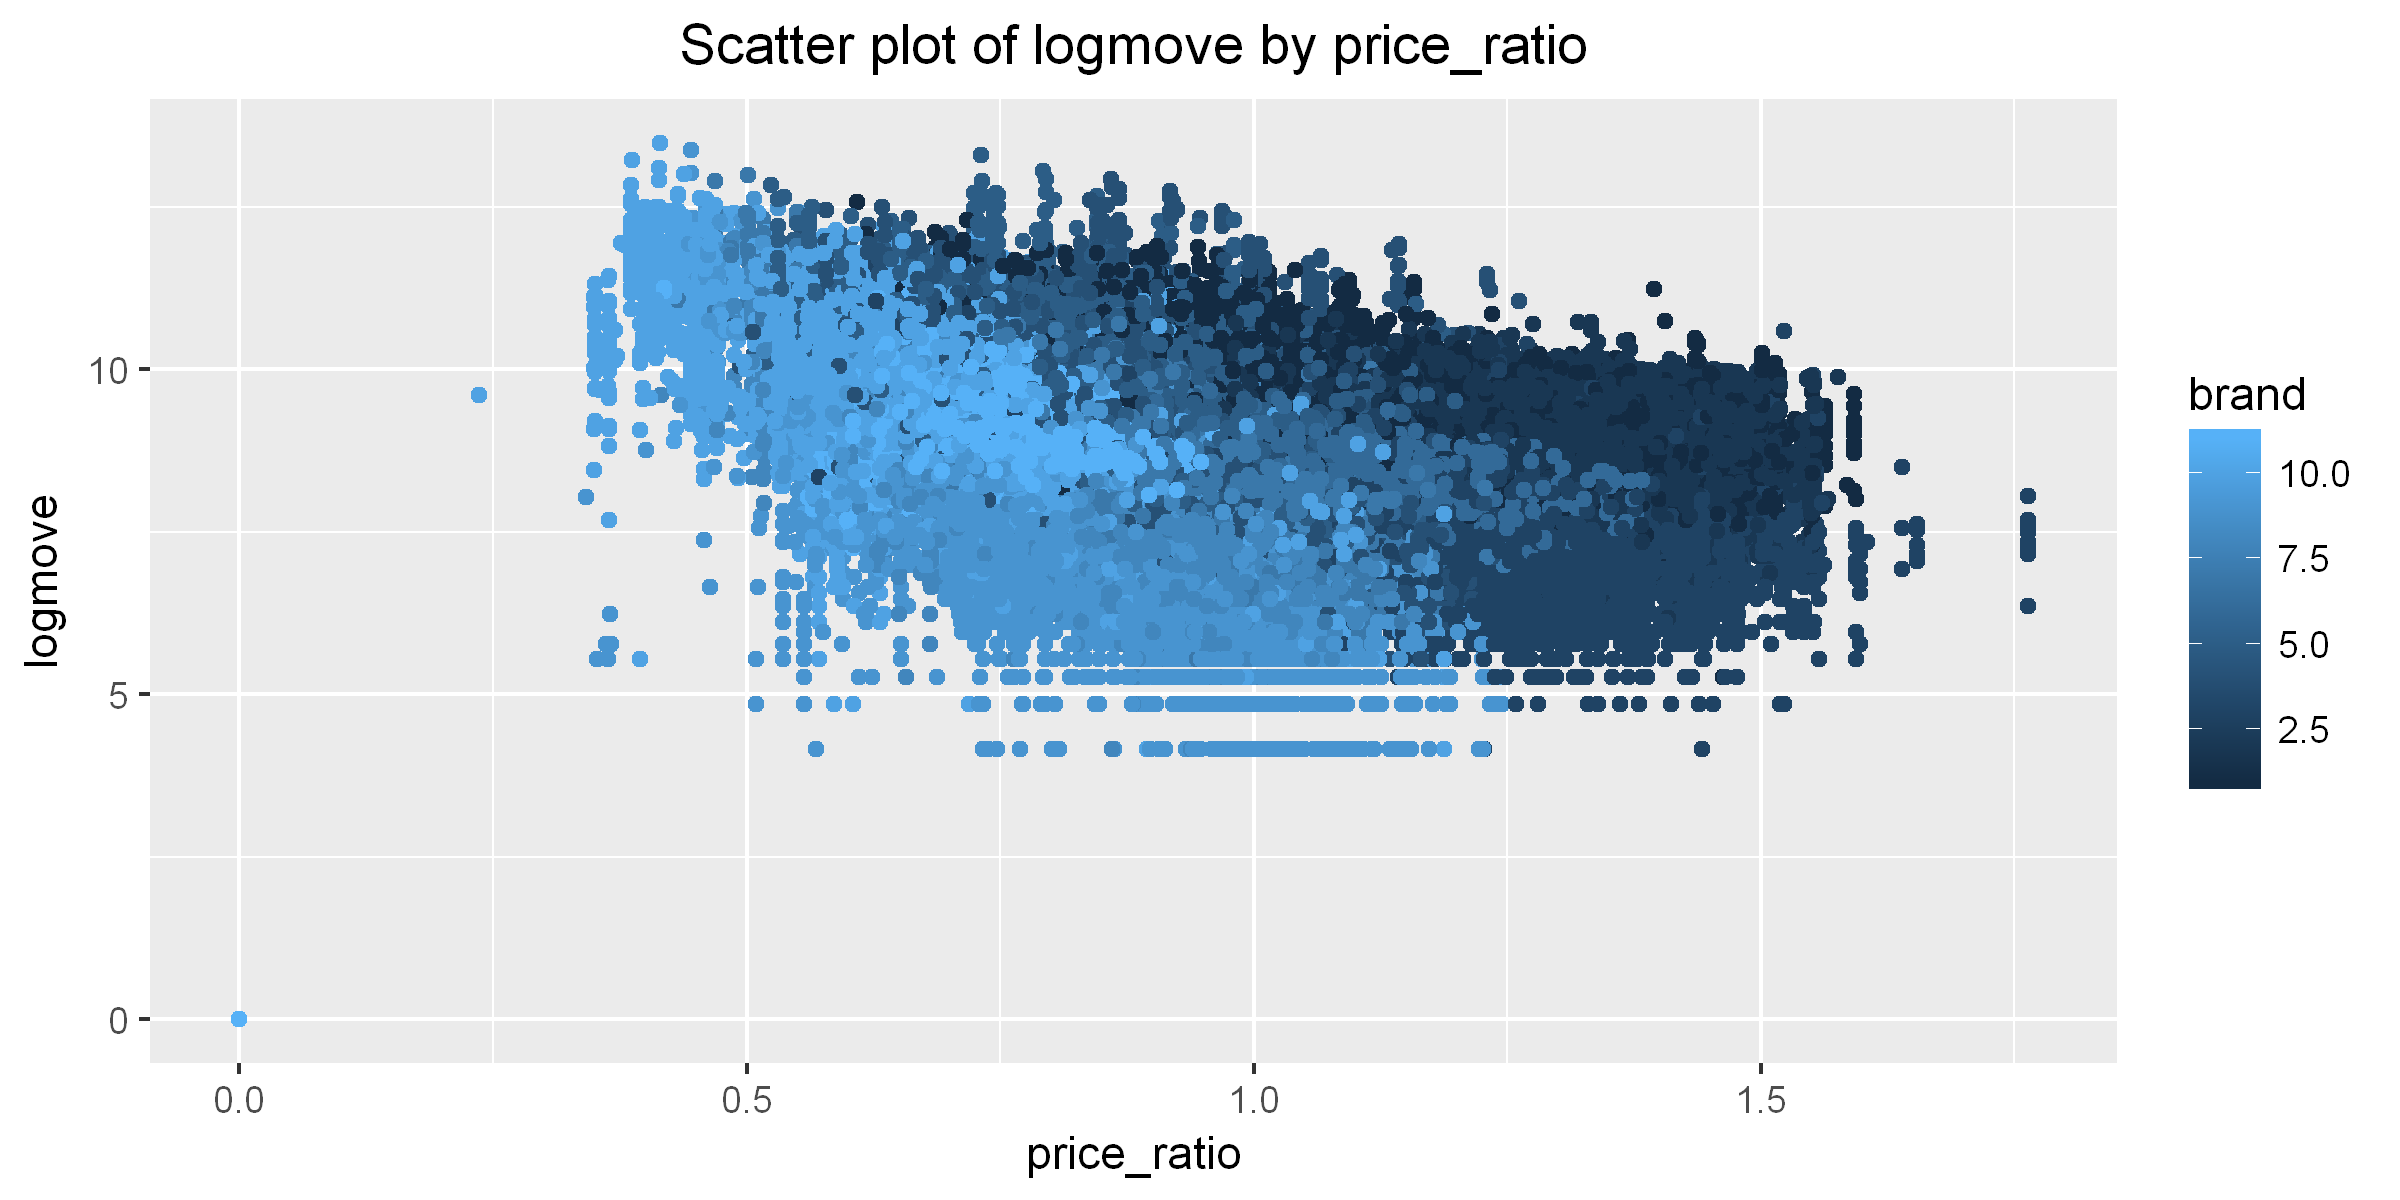

In [17]:
ggplot(sales, aes(price, logmove, color=brand)) + geom_point() +
 ggtitle('Scatter plot of logmove by price') +
 theme(plot.title = element_text(hjust = 0.5))
ggplot(sales, aes(price_ratio, logmove, color=brand)) + geom_point() +
 ggtitle('Scatter plot of logmove by price_ratio') +
 theme(plot.title = element_text(hjust = 0.5))

## Impact of holidays 

It seems that the holidays don't have a significant and consistent impact on sales of orange juices.

In [18]:
# Read holiday information
week_decoder <- read.csv('./data/week_decoder.csv')
colnames(week_decoder) <- c('week', 'start_date', 'end_date', 'special_events')
sales <- merge(x=sales, y=week_decoder, by='week', all.x=TRUE)

In [19]:
sales <- sales[!(sales$logmove==0),] # For removing the impact of 0 values that we filled
sum <- summary(sales$logmove)
sum['Std'] <- round(sd(sales$logmove), 2)
print(sum)
sales %>% group_by(special_events) %>% summarise(Count=n(), 
                                                 Mean=mean(logmove), 
                                                 Std=sd(logmove), 
                                                 Min=min(logmove), 
                                                 FirstQu =quantile(logmove,0.25), 
                                                 Median=median(logmove), 
                                                 ThirdQu =quantile(logmove,0.75), 
                                                 Max=max(logmove))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.     Std 
  4.159   7.700   8.393   8.417   9.049  13.482   1.140 


special_events,Count,Mean,Std,Min,FirstQu,Median,ThirdQu,Max
,88660,8.418506,1.1345550,4.158883,7.714231,8.392990,9.041685,13.48202
4th of July,2475,8.282183,1.2258358,4.158883,7.592870,8.302018,8.962904,11.85918
Christmas,1804,8.492180,1.1775679,4.158883,7.714231,8.534640,9.284331,11.63988
Easter,1793,8.569481,1.4355083,4.158883,7.624619,8.476371,9.300547,12.93258
Halloween,1793,8.296399,0.9710761,4.158883,7.699842,8.184235,8.691483,11.57886
Labor Day,2574,8.389046,1.0707218,4.158883,7.796469,8.378391,9.041685,11.41800
Memorial Day,1738,8.457200,1.0774811,5.257495,7.655391,8.442446,9.176163,11.60372
New-Year,1749,8.542589,1.1796061,5.545177,7.624619,8.601534,9.379239,11.63875
Presidents Day,1749,8.367503,1.3241963,4.158883,7.491088,8.236421,8.929568,13.04792
Thanksgiving,1804,8.376448,1.0316020,4.158883,7.796469,8.449343,9.053919,11.25395


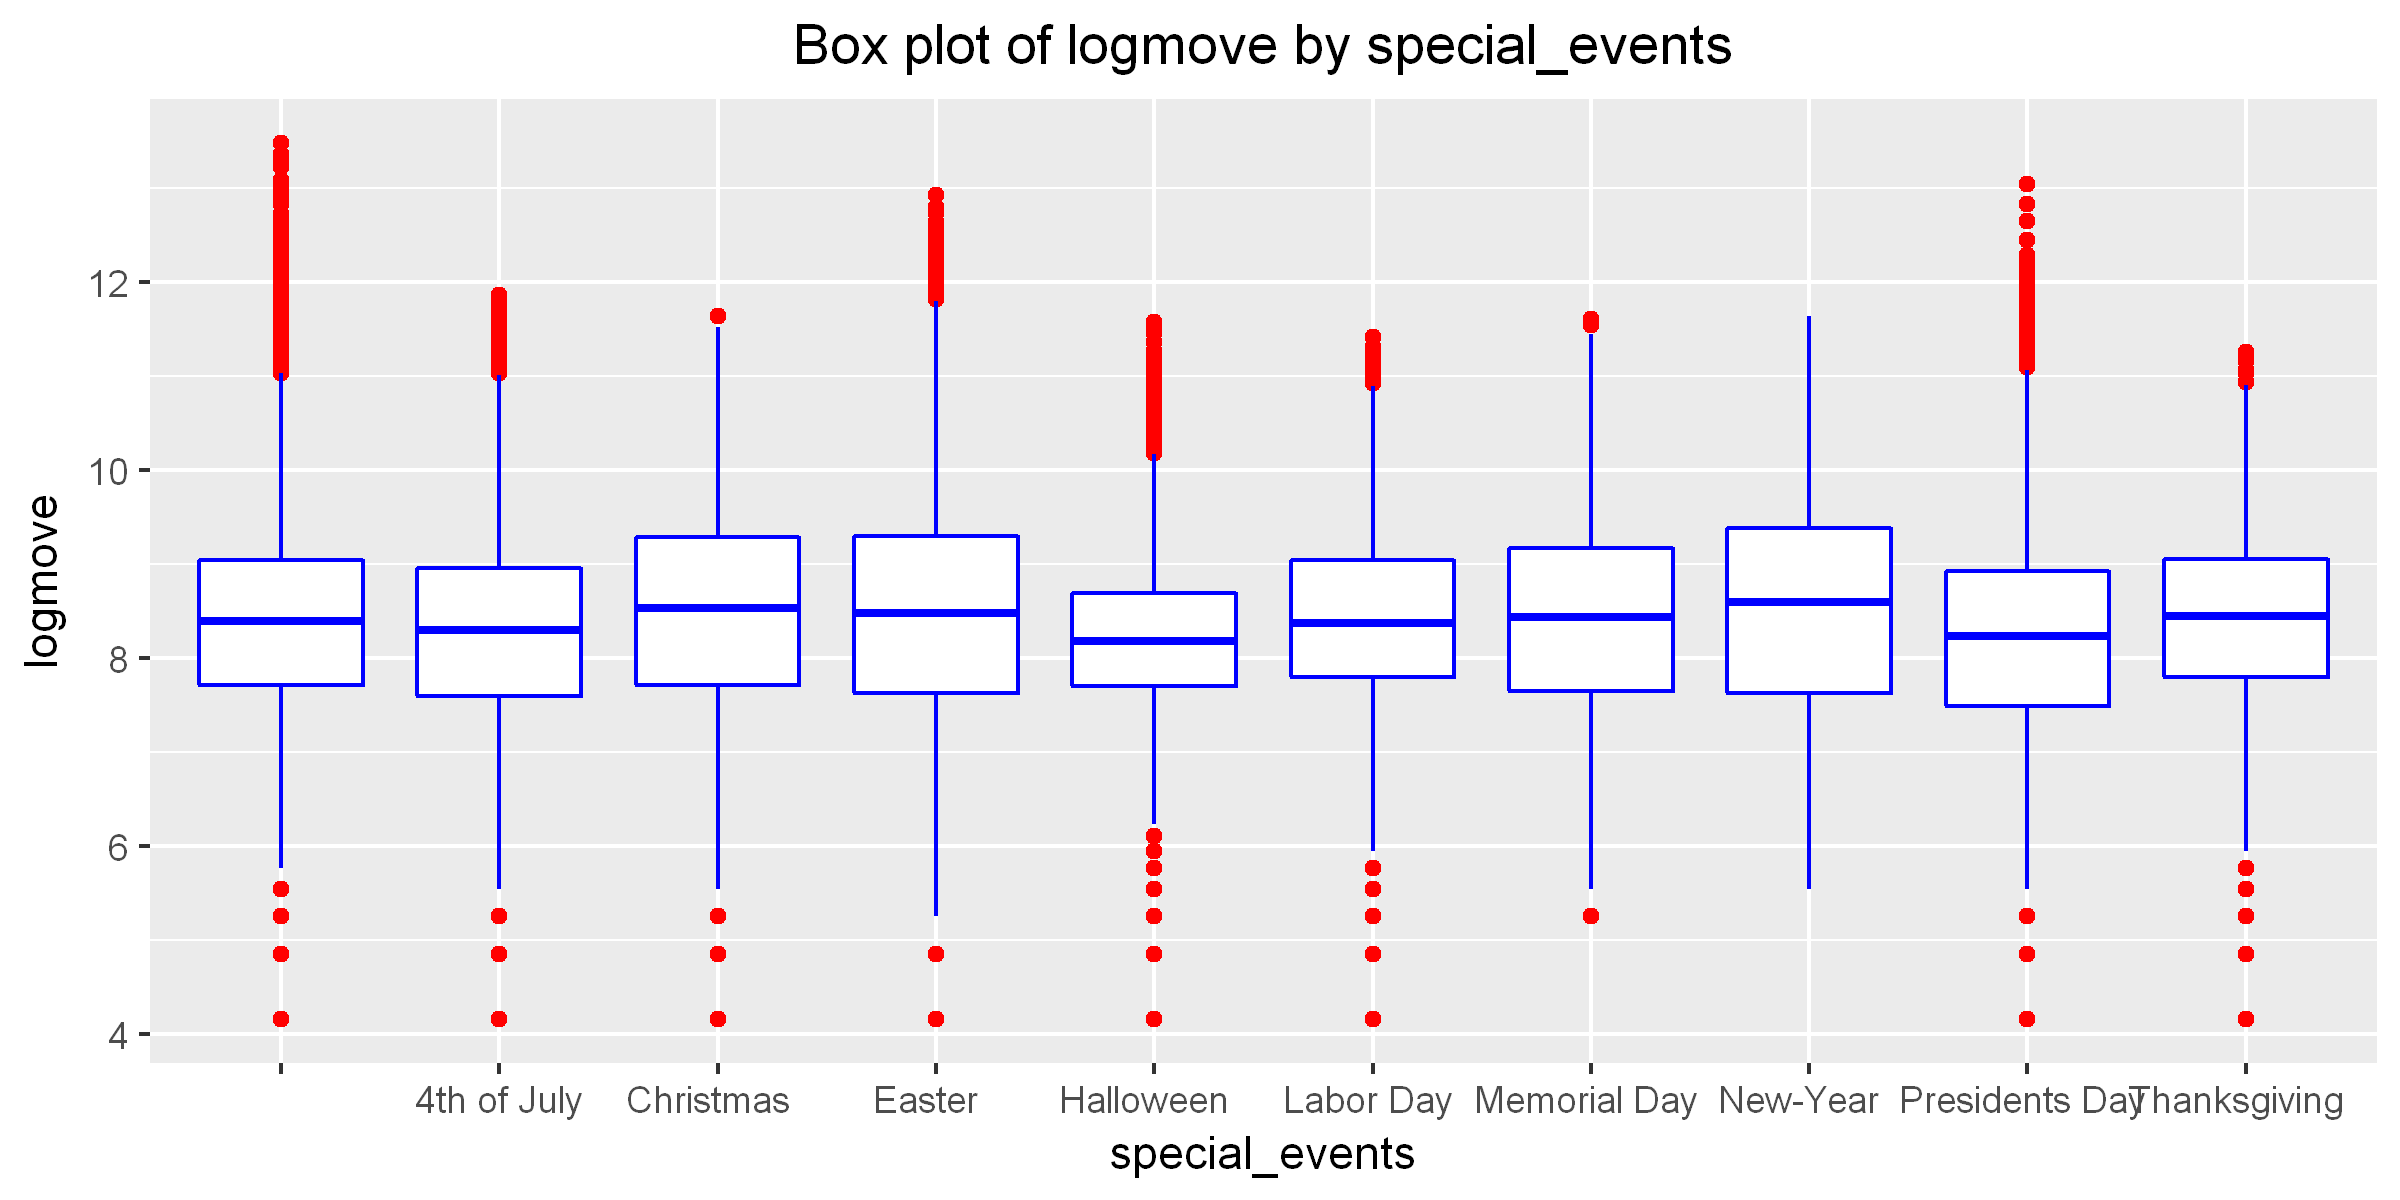

In [20]:
ggplot(sales, aes(x=special_events, y=logmove, group=special_events)) + geom_boxplot(color='blue', outlier.color='red') +
 ggtitle('Box plot of logmove by special_events') +
 theme(plot.title = element_text(hjust = 0.5))